# Task description

Accurately predicting future demand is key for success in hospitality industry, since a demand forecast helps with planning of inventory or staffing.

We are going to predict future daily sales for all locations of one restaurant chain. The prediction will provide daily sales for 7 days ahead.

I.e., the output is: for each location predicted daily sales, for 7 days ahead are returned.

| location | Date of Prediction | Forecast day 1 | Forecast day 2 | Forecast day 3 | …   | Forecast day 7 |
|----------|--------------------|----------------|----------------|----------------|-----|----------------|
| 9809     | 2019-12-01         | 500            | 530            | 480            | ... | 830            |
| 9810     | 2019-12-01         | 1250           | 1300           | 600            | ... | 1670           |


## Output

- Predictive model (end-to-end; from input data to the output predictions; both training and scoring) in Python
- Modelling documentation

## Data

Use data provided in the file `restaurant_data.csv`. The data contain daily sales data for 163 locations over a span of 25 months – 1 December 2017 and 31 December 2019.

We are going to demonstrate the performance of the model for December 2019.

All locations are from the same restaurant chain in London.

### Header
- location – id of the restaurant
- date - date
- sales – aggregated daily sales



In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns #visualization
import matplotlib.pyplot as plt #visualization
import xgboost as xgb #modelling
from xgboost import plot_importance, plot_tree #supporting modelling
from sklearn.metrics import mean_squared_error, mean_absolute_error #scoring

In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')
file_location = '/content/drive/My Drive/Colab Notebooks'

Mounted at /content/drive


In [3]:
df = pd.read_csv(os.path.join(file_location,"restaurant_data.csv"))

Data Exploration

In [4]:
df.head()

,location,date,sales
0,9708,2017-12-01,5371.933333
1,9708,2017-12-02,6789.400000
2,9708,2017-12-03,2437.080000
3,9708,2017-12-04,1395.700000
4,9708,2017-12-05,2020.300000


In [5]:
df.dtypes

,0
location,int64
date,object
sales,float64


We would most likely need to parse the date at some point.

In [6]:
print("Total missing: " + str(df.isnull().sum()))
print("Total duplicates: "+ str(df.duplicated().sum()))

Total missing: location    0
date        0
sales       0
dtype: int64
Total duplicates: 0


In [7]:
df_records_per_loc = pd.DataFrame(df.location.value_counts())
df_records_per_loc.head()
df_records_per_loc.sort_values(by="count", ascending=True)

,count
location,
15505,12
15512,20
14793,54
14786,62
14768,69
...,...
9760,753
9708,753
9819,754


In [8]:
df.sales.describe()

,sales
count,95667.000000
mean,2536.081158
std,1655.559973
min,-99.600000
25%,1492.216667
50%,2107.706667
75%,3109.440000
max,24770.633333


Observations
1. Potential outliers with negative or 0 value of sales. I am going to assume that these are representing missing values either dates at which the restaurants are closed or the data has been corrupted. Negatives might be dates at which the restaurant was closed and refunds were performed.
2. No duplicates.

In [9]:
df[df['sales']<=0]

,location,date,sales
290,9708,2018-09-20,-5.133333
379,9708,2018-12-18,0.000000
616,9708,2019-08-15,0.000000
626,9708,2019-08-25,0.000000
648,9708,2019-09-16,0.000000
...,...,...,...
95460,14775,2019-11-02,-10.366667
95501,14775,2019-12-13,-5.166667
95516,14775,2019-12-29,0.000000
95519,14786,2019-10-28,0.000000


In [10]:
df_aggregated_loc = pd.DataFrame(df.groupby(['location'])['sales'].agg('sum'))
df_aggregated_date = pd.DataFrame(df.groupby(['date'])['sales'].agg('sum'))

In [11]:
df_aggregated_loc.describe()

,sales
count,1.630000e+02
mean,1.488462e+06
std,7.901724e+05
min,3.767695e+04
25%,9.908902e+05
50%,1.519823e+06
75%,1.927443e+06
max,4.665828e+06


In [12]:
df_aggregated_date.describe()

,sales
count,758.000000
mean,320078.200661
std,153272.881526
min,414.720000
25%,207793.068333
50%,280613.856667
75%,404687.801667
max,910935.644133


In [13]:
df_records_per_loc = pd.DataFrame(df.location.value_counts())
df_records_per_loc.describe()

,count
count,163.000000
mean,586.914110
std,234.085122
min,12.000000
25%,462.000000
50%,741.000000
75%,749.000000
max,756.000000


In [14]:
#get abnormal
df_outliers = df_records_per_loc[df_records_per_loc["count"]<100]

We are going to check if there are missing periods by checking the difference of the maximum and minimum date against the counts of the date values:


1.   We are going to get aggregated maximum and minimum date for each location.
2.   The count of rows for records per location.
3.    Finally we are going to check if there is a difference between the days from minimum to maximum date and the count and mark them with a flag.



In [15]:
#check if there are missing dates
df_aggregated_max_date = pd.DataFrame(df.groupby(['location'])['date'].agg('max'))
df_aggregated_min_date = pd.DataFrame(df.groupby(['location'])['date'].agg('min'))
df_aggregated_counts = pd.DataFrame(df.groupby(['location'])['date'].agg('count'))
df_aggregated_counts.rename(columns={'date':'row_count'}, inplace=True)
print(df_aggregated_counts)
print(df_aggregated_max_date['date'])

          row_count
location           
9708            753
9710            752
9712            752
9714            752
9716            752
...             ...
14775            89
14786            62
14793            54
15505            12
15512            20

[163 rows x 1 columns]
location
9708     2019-12-31
9710     2019-12-31
9712     2019-12-31
9714     2019-12-31
9716     2019-12-31
            ...    
14775    2019-12-31
14786    2019-12-31
14793    2019-12-31
15505    2019-12-31
15512    2019-12-31
Name: date, Length: 163, dtype: object


In [16]:
df_aggregated_max_date['date'] = pd.to_datetime(df_aggregated_max_date['date'].str.strip(), format='%Y-%m-%d')
df_aggregated_min_date['date'] = pd.to_datetime(df_aggregated_min_date['date'].str.strip(), format='%Y-%m-%d')
df_aggregated_max_date.rename(columns={'date':'max_date'}, inplace=True)
df_aggregated_min_date.rename(columns={'date':'min_date'}, inplace=True)
df_max_min_date = df_aggregated_max_date.merge(df_aggregated_min_date, left_index=True, right_index=True)

In [17]:
df_max_min_date.dtypes

,0
max_date,datetime64[ns]
min_date,datetime64[ns]


In [18]:
df_max_min_date['date_range_count'] = (df_max_min_date['max_date'] - df_max_min_date['min_date']) / np.timedelta64(1, 'D')
df_max_min_date['date_range_count'] = df_max_min_date['date_range_count'].apply(np.int64)

In [19]:
df_date_range_check = df_max_min_date.merge(df_aggregated_counts, left_index=True, right_index=True)

In [20]:
df_date_range_check.head()

,max_date,min_date,date_range_count,row_count
location,,,,
9708,2019-12-31,2017-12-01,760,753
9710,2019-12-31,2017-12-01,760,752
9712,2019-12-31,2017-12-01,760,752
9714,2019-12-31,2017-12-01,760,752
9716,2019-12-31,2017-12-01,760,752


In [21]:
df_date_range_check['missing_dates_flag'] = df_date_range_check.apply(lambda x: 1 if x['date_range_count']-x['row_count']!=0 else 0, axis=1)

There are clearly missing values as we can see on the counts below:

In [22]:
df_date_range_check['missing_dates_flag'].value_counts()

,count
missing_dates_flag,
1,160
0,3


In [23]:
df['date_dt'] = pd.to_datetime(df['date'].str.strip(), format='%Y-%m-%d')
df_viz = df.set_index("date_dt")

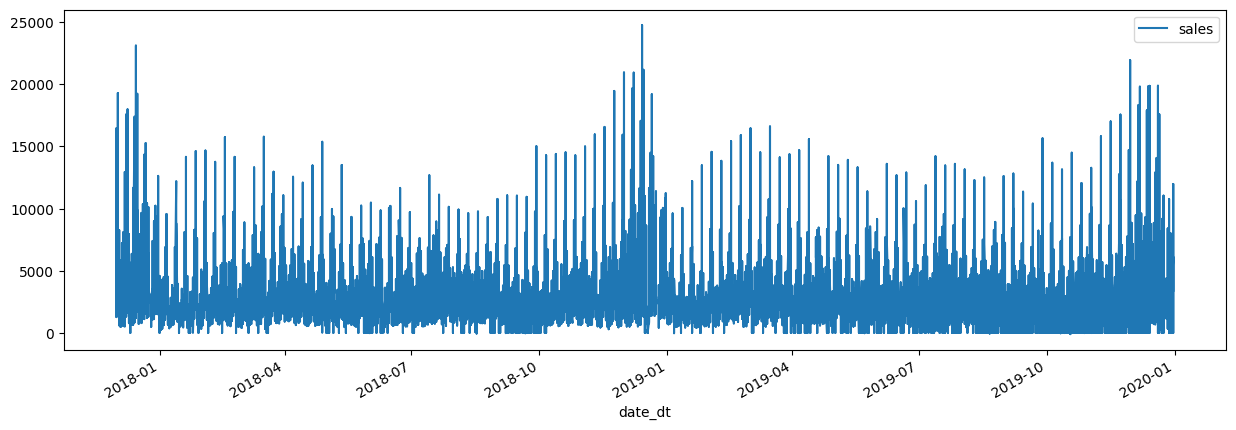

In [24]:
_ = df_viz[['sales']].plot(figsize=(15, 5))

There is an apparent seasonality in the data. With peaks of sales in December and January across most locations.

Feature Engineering
- 7 day lag
- date based features
- bank holidays in London

Since we have spotten that there are missing ranges it is going to be incorrect to get the lag as a mere row shift -  we are going to use the date column instead.

In [25]:
df_lags = df.copy()
df_lags['lag_date'] =  df_lags['date_dt'] + pd.Timedelta(days=7)
df_lags.rename(columns={'sales':'Lag7'}, inplace=True)
df_lags.drop(columns=['date', 'date_dt'], inplace=True)

In [26]:
df_lags.head()

,location,Lag7,lag_date
0,9708,5371.933333,2017-12-08
1,9708,6789.400000,2017-12-09
2,9708,2437.080000,2017-12-10
3,9708,1395.700000,2017-12-11
4,9708,2020.300000,2017-12-12


In [27]:
df.head()

,location,date,sales,date_dt
0,9708,2017-12-01,5371.933333,2017-12-01
1,9708,2017-12-02,6789.400000,2017-12-02
2,9708,2017-12-03,2437.080000,2017-12-03
3,9708,2017-12-04,1395.700000,2017-12-04
4,9708,2017-12-05,2020.300000,2017-12-05


In [28]:
df = df.merge(df_lags, left_on=['location', 'date_dt'], right_on=['location', 'lag_date'], how='left')
df.drop(columns=['lag_date'], inplace=True)

In [29]:
df.isnull().sum()

,0
location,0
date,0
sales,0
date_dt,0
Lag7,2551


In [30]:
df['dayofweek'] = df['date_dt'].dt.dayofweek
df['month'] = df['date_dt'].dt.month
df['dayofyear'] = df['date_dt'].dt.dayofyear
df['dayofmonth'] = df['date_dt'].dt.day

 Holidays <br>
Data taken from: <br>
https://www.gov.uk/bank-holidays.json <br>
https://www.officeholidays.com/countries/united-kingdom/2017

Raw data:
<br>(Sorry for just pasting it here, I wanted to make sure the notebook is reproducible)

In [31]:
holidays_dict = {"england-and-wales":{"division":"england-and-wales","events":[{"title":"New Year’s Day","date":"2018-01-01","notes":"","bunting":True},{"title":"Good Friday","date":"2018-03-30","notes":"","bunting":False},{"title":"Easter Monday","date":"2018-04-02","notes":"","bunting":True},{"title":"Early May bank holiday","date":"2018-05-07","notes":"","bunting":True},{"title":"Spring bank holiday","date":"2018-05-28","notes":"","bunting":True},{"title":"Summer bank holiday","date":"2018-08-27","notes":"","bunting":True},{"title":"Christmas Day","date":"2018-12-25","notes":"","bunting":True},{"title":"Boxing Day","date":"2018-12-26","notes":"","bunting":True},{"title":"New Year’s Day","date":"2019-01-01","notes":"","bunting":True},{"title":"Good Friday","date":"2019-04-19","notes":"","bunting":False},{"title":"Easter Monday","date":"2019-04-22","notes":"","bunting":True},{"title":"Early May bank holiday","date":"2019-05-06","notes":"","bunting":True},{"title":"Spring bank holiday","date":"2019-05-27","notes":"","bunting":True},{"title":"Summer bank holiday","date":"2019-08-26","notes":"","bunting":True},{"title":"Christmas Day","date":"2019-12-25","notes":"","bunting":True},{"title":"Boxing Day","date":"2019-12-26","notes":"","bunting":True},{"title":"New Year’s Day","date":"2020-01-01","notes":"","bunting":True},{"title":"Good Friday","date":"2020-04-10","notes":"","bunting":False},{"title":"Easter Monday","date":"2020-04-13","notes":"","bunting":False},{"title":"Early May bank holiday (VE day)","date":"2020-05-08","notes":"","bunting":True},{"title":"Spring bank holiday","date":"2020-05-25","notes":"","bunting":True},{"title":"Summer bank holiday","date":"2020-08-31","notes":"","bunting":True},{"title":"Christmas Day","date":"2020-12-25","notes":"","bunting":True},{"title":"Boxing Day","date":"2020-12-28","notes":"Substitute day","bunting":True},{"title":"New Year’s Day","date":"2021-01-01","notes":"","bunting":True},{"title":"Good Friday","date":"2021-04-02","notes":"","bunting":False},{"title":"Easter Monday","date":"2021-04-05","notes":"","bunting":True},{"title":"Early May bank holiday","date":"2021-05-03","notes":"","bunting":True},{"title":"Spring bank holiday","date":"2021-05-31","notes":"","bunting":True},{"title":"Summer bank holiday","date":"2021-08-30","notes":"","bunting":True},{"title":"Christmas Day","date":"2021-12-27","notes":"Substitute day","bunting":True},{"title":"Boxing Day","date":"2021-12-28","notes":"Substitute day","bunting":True},{"title":"New Year’s Day","date":"2022-01-03","notes":"Substitute day","bunting":True},{"title":"Good Friday","date":"2022-04-15","notes":"","bunting":False},{"title":"Easter Monday","date":"2022-04-18","notes":"","bunting":True},{"title":"Early May bank holiday","date":"2022-05-02","notes":"","bunting":True},{"title":"Spring bank holiday","date":"2022-06-02","notes":"","bunting":True},{"title":"Platinum Jubilee bank holiday","date":"2022-06-03","notes":"","bunting":True},{"title":"Summer bank holiday","date":"2022-08-29","notes":"","bunting":True},{"title":"Bank Holiday for the State Funeral of Queen Elizabeth II","date":"2022-09-19","notes":"","bunting":False},{"title":"Boxing Day","date":"2022-12-26","notes":"","bunting":True},{"title":"Christmas Day","date":"2022-12-27","notes":"Substitute day","bunting":True},{"title":"New Year’s Day","date":"2023-01-02","notes":"Substitute day","bunting":True},{"title":"Good Friday","date":"2023-04-07","notes":"","bunting":False},{"title":"Easter Monday","date":"2023-04-10","notes":"","bunting":True},{"title":"Early May bank holiday","date":"2023-05-01","notes":"","bunting":True},{"title":"Bank holiday for the coronation of King Charles III","date":"2023-05-08","notes":"","bunting":True},{"title":"Spring bank holiday","date":"2023-05-29","notes":"","bunting":True},{"title":"Summer bank holiday","date":"2023-08-28","notes":"","bunting":True},{"title":"Christmas Day","date":"2023-12-25","notes":"","bunting":True},{"title":"Boxing Day","date":"2023-12-26","notes":"","bunting":True},{"title":"New Year’s Day","date":"2024-01-01","notes":"","bunting":True},{"title":"Good Friday","date":"2024-03-29","notes":"","bunting":False},{"title":"Easter Monday","date":"2024-04-01","notes":"","bunting":True},{"title":"Early May bank holiday","date":"2024-05-06","notes":"","bunting":True},{"title":"Spring bank holiday","date":"2024-05-27","notes":"","bunting":True},{"title":"Summer bank holiday","date":"2024-08-26","notes":"","bunting":True},{"title":"Christmas Day","date":"2024-12-25","notes":"","bunting":True},{"title":"Boxing Day","date":"2024-12-26","notes":"","bunting":True},{"title":"New Year’s Day","date":"2025-01-01","notes":"","bunting":True},{"title":"Good Friday","date":"2025-04-18","notes":"","bunting":False},{"title":"Easter Monday","date":"2025-04-21","notes":"","bunting":True},{"title":"Early May bank holiday","date":"2025-05-05","notes":"","bunting":True},{"title":"Spring bank holiday","date":"2025-05-26","notes":"","bunting":True},{"title":"Summer bank holiday","date":"2025-08-25","notes":"","bunting":True},{"title":"Christmas Day","date":"2025-12-25","notes":"","bunting":True},{"title":"Boxing Day","date":"2025-12-26","notes":"","bunting":True},{"title":"New Year’s Day","date":"2026-01-01","notes":"","bunting":True},{"title":"Good Friday","date":"2026-04-03","notes":"","bunting":False},{"title":"Easter Monday","date":"2026-04-06","notes":"","bunting":True},{"title":"Early May bank holiday","date":"2026-05-04","notes":"","bunting":True},{"title":"Spring bank holiday","date":"2026-05-25","notes":"","bunting":True},{"title":"Summer bank holiday","date":"2026-08-31","notes":"","bunting":True},{"title":"Christmas Day","date":"2026-12-25","notes":"","bunting":True},{"title":"Boxing Day","date":"2026-12-28","notes":"Substitute day","bunting":True}]},"scotland":{"division":"scotland","events":[{"title":"New Year’s Day","date":"2018-01-01","notes":"","bunting":True},{"title":"2nd January","date":"2018-01-02","notes":"","bunting":True},{"title":"Good Friday","date":"2018-03-30","notes":"","bunting":False},{"title":"Early May bank holiday","date":"2018-05-07","notes":"","bunting":True},{"title":"Spring bank holiday","date":"2018-05-28","notes":"","bunting":True},{"title":"Summer bank holiday","date":"2018-08-06","notes":"","bunting":True},{"title":"St Andrew’s Day","date":"2018-11-30","notes":"","bunting":True},{"title":"Christmas Day","date":"2018-12-25","notes":"","bunting":True},{"title":"Boxing Day","date":"2018-12-26","notes":"","bunting":True},{"title":"New Year’s Day","date":"2019-01-01","notes":"","bunting":True},{"title":"2nd January","date":"2019-01-02","notes":"","bunting":True},{"title":"Good Friday","date":"2019-04-19","notes":"","bunting":False},{"title":"Early May bank holiday","date":"2019-05-06","notes":"","bunting":True},{"title":"Spring bank holiday","date":"2019-05-27","notes":"","bunting":True},{"title":"Summer bank holiday","date":"2019-08-05","notes":"","bunting":True},{"title":"St Andrew’s Day","date":"2019-12-02","notes":"Substitute day","bunting":True},{"title":"Christmas Day","date":"2019-12-25","notes":"","bunting":True},{"title":"Boxing Day","date":"2019-12-26","notes":"","bunting":True},{"title":"New Year’s Day","date":"2020-01-01","notes":"","bunting":True},{"title":"2nd January","date":"2020-01-02","notes":"","bunting":True},{"title":"Good Friday","date":"2020-04-10","notes":"","bunting":False},{"title":"Early May bank holiday (VE day)","date":"2020-05-08","notes":"","bunting":True},{"title":"Spring bank holiday","date":"2020-05-25","notes":"","bunting":True},{"title":"Summer bank holiday","date":"2020-08-03","notes":"","bunting":True},{"title":"St Andrew’s Day","date":"2020-11-30","notes":"","bunting":True},{"title":"Christmas Day","date":"2020-12-25","notes":"","bunting":True},{"title":"Boxing Day","date":"2020-12-28","notes":"Substitute day","bunting":True},{"title":"New Year’s Day","date":"2021-01-01","notes":"","bunting":True},{"title":"2nd January","date":"2021-01-04","notes":"Substitute day","bunting":True},{"title":"Good Friday","date":"2021-04-02","notes":"","bunting":False},{"title":"Early May bank holiday","date":"2021-05-03","notes":"","bunting":True},{"title":"Spring bank holiday","date":"2021-05-31","notes":"","bunting":True},{"title":"Summer bank holiday","date":"2021-08-02","notes":"","bunting":True},{"title":"St Andrew’s Day","date":"2021-11-30","notes":"","bunting":True},{"title":"Christmas Day","date":"2021-12-27","notes":"Substitute day","bunting":True},{"title":"Boxing Day","date":"2021-12-28","notes":"Substitute day","bunting":True},{"title":"New Year’s Day","date":"2022-01-03","notes":"Substitute day","bunting":True},{"title":"2nd January","date":"2022-01-04","notes":"Substitute day","bunting":True},{"title":"Good Friday","date":"2022-04-15","notes":"","bunting":False},{"title":"Early May bank holiday","date":"2022-05-02","notes":"","bunting":True},{"title":"Spring bank holiday","date":"2022-06-02","notes":"","bunting":True},{"title":"Platinum Jubilee bank holiday","date":"2022-06-03","notes":"","bunting":True},{"title":"Summer bank holiday","date":"2022-08-01","notes":"","bunting":True},{"title":"Bank Holiday for the State Funeral of Queen Elizabeth II","date":"2022-09-19","notes":"","bunting":False},{"title":"St Andrew’s Day","date":"2022-11-30","notes":"","bunting":True},{"title":"Boxing Day","date":"2022-12-26","notes":"","bunting":True},{"title":"Christmas Day","date":"2022-12-27","notes":"Substitute day","bunting":True},{"title":"New Year’s Day","date":"2023-01-02","notes":"Substitute day","bunting":True},{"title":"2nd January","date":"2023-01-03","notes":"Substitute day","bunting":True},{"title":"Good Friday","date":"2023-04-07","notes":"","bunting":False},{"title":"Early May bank holiday","date":"2023-05-01","notes":"","bunting":True},{"title":"Bank holiday for the coronation of King Charles III","date":"2023-05-08","notes":"","bunting":True},{"title":"Spring bank holiday","date":"2023-05-29","notes":"","bunting":True},{"title":"Summer bank holiday","date":"2023-08-07","notes":"","bunting":True},{"title":"St Andrew’s Day","date":"2023-11-30","notes":"","bunting":True},{"title":"Christmas Day","date":"2023-12-25","notes":"","bunting":True},{"title":"Boxing Day","date":"2023-12-26","notes":"","bunting":True},{"title":"New Year’s Day","date":"2024-01-01","notes":"","bunting":True},{"title":"2nd January","date":"2024-01-02","notes":"","bunting":True},{"title":"Good Friday","date":"2024-03-29","notes":"","bunting":False},{"title":"Early May bank holiday","date":"2024-05-06","notes":"","bunting":True},{"title":"Spring bank holiday","date":"2024-05-27","notes":"","bunting":True},{"title":"Summer bank holiday","date":"2024-08-05","notes":"","bunting":True},{"title":"St Andrew’s Day","date":"2024-12-02","notes":"Substitute day","bunting":True},{"title":"Christmas Day","date":"2024-12-25","notes":"","bunting":True},{"title":"Boxing Day","date":"2024-12-26","notes":"","bunting":True},{"title":"New Year’s Day","date":"2025-01-01","notes":"","bunting":True},{"title":"2nd January","date":"2025-01-02","notes":"","bunting":True},{"title":"Good Friday","date":"2025-04-18","notes":"","bunting":False},{"title":"Early May bank holiday","date":"2025-05-05","notes":"","bunting":True},{"title":"Spring bank holiday","date":"2025-05-26","notes":"","bunting":True},{"title":"Summer bank holiday","date":"2025-08-04","notes":"","bunting":True},{"title":"St Andrew’s Day","date":"2025-12-01","notes":"Substitute day","bunting":True},{"title":"Christmas Day","date":"2025-12-25","notes":"","bunting":True},{"title":"Boxing Day","date":"2025-12-26","notes":"","bunting":True},{"title":"New Year’s Day","date":"2026-01-01","notes":"","bunting":True},{"title":"2nd January","date":"2026-01-02","notes":"","bunting":True},{"title":"Good Friday","date":"2026-04-03","notes":"","bunting":False},{"title":"Early May bank holiday","date":"2026-05-04","notes":"","bunting":True},{"title":"Spring bank holiday","date":"2026-05-25","notes":"","bunting":True},{"title":"Summer bank holiday","date":"2026-08-03","notes":"","bunting":True},{"title":"St Andrew’s Day","date":"2026-11-30","notes":"","bunting":True},{"title":"Christmas Day","date":"2026-12-25","notes":"","bunting":True},{"title":"Boxing Day","date":"2026-12-28","notes":"Substitute day","bunting":True}]},"northern-ireland":{"division":"northern-ireland","events":[{"title":"New Year’s Day","date":"2018-01-01","notes":"","bunting":True},{"title":"St Patrick’s Day","date":"2018-03-19","notes":"Substitute day","bunting":True},{"title":"Good Friday","date":"2018-03-30","notes":"","bunting":False},{"title":"Easter Monday","date":"2018-04-02","notes":"","bunting":True},{"title":"Early May bank holiday","date":"2018-05-07","notes":"","bunting":True},{"title":"Spring bank holiday","date":"2018-05-28","notes":"","bunting":True},{"title":"Battle of the Boyne (Orangemen’s Day)","date":"2018-07-12","notes":"","bunting":False},{"title":"Summer bank holiday","date":"2018-08-27","notes":"","bunting":True},{"title":"Christmas Day","date":"2018-12-25","notes":"","bunting":True},{"title":"Boxing Day","date":"2018-12-26","notes":"","bunting":True},{"title":"New Year’s Day","date":"2019-01-01","notes":"","bunting":True},{"title":"St Patrick’s Day","date":"2019-03-18","notes":"Substitute day","bunting":True},{"title":"Good Friday","date":"2019-04-19","notes":"","bunting":False},{"title":"Easter Monday","date":"2019-04-22","notes":"","bunting":True},{"title":"Early May bank holiday","date":"2019-05-06","notes":"","bunting":True},{"title":"Spring bank holiday","date":"2019-05-27","notes":"","bunting":True},{"title":"Battle of the Boyne (Orangemen’s Day)","date":"2019-07-12","notes":"","bunting":False},{"title":"Summer bank holiday","date":"2019-08-26","notes":"","bunting":True},{"title":"Christmas Day","date":"2019-12-25","notes":"","bunting":True},{"title":"Boxing Day","date":"2019-12-26","notes":"","bunting":True},{"title":"New Year’s Day","date":"2020-01-01","notes":"","bunting":True},{"title":"St Patrick’s Day","date":"2020-03-17","notes":"","bunting":True},{"title":"Good Friday","date":"2020-04-10","notes":"","bunting":False},{"title":"Easter Monday","date":"2020-04-13","notes":"","bunting":False},{"title":"Early May bank holiday (VE day)","date":"2020-05-08","notes":"","bunting":True},{"title":"Spring bank holiday","date":"2020-05-25","notes":"","bunting":True},{"title":"Battle of the Boyne (Orangemen’s Day)","date":"2020-07-13","notes":"Substitute day","bunting":False},{"title":"Summer bank holiday","date":"2020-08-31","notes":"","bunting":True},{"title":"Christmas Day","date":"2020-12-25","notes":"","bunting":True},{"title":"Boxing Day","date":"2020-12-28","notes":"Substitute day","bunting":True},{"title":"New Year’s Day","date":"2021-01-01","notes":"","bunting":True},{"title":"St Patrick’s Day","date":"2021-03-17","notes":"","bunting":True},{"title":"Good Friday","date":"2021-04-02","notes":"","bunting":False},{"title":"Easter Monday","date":"2021-04-05","notes":"","bunting":True},{"title":"Early May bank holiday","date":"2021-05-03","notes":"","bunting":True},{"title":"Spring bank holiday","date":"2021-05-31","notes":"","bunting":True},{"title":"Battle of the Boyne (Orangemen’s Day)","date":"2021-07-12","notes":"","bunting":False},{"title":"Summer bank holiday","date":"2021-08-30","notes":"","bunting":True},{"title":"Christmas Day","date":"2021-12-27","notes":"Substitute day","bunting":True},{"title":"Boxing Day","date":"2021-12-28","notes":"Substitute day","bunting":True},{"title":"New Year’s Day","date":"2022-01-03","notes":"Substitute day","bunting":True},{"title":"St Patrick’s Day","date":"2022-03-17","notes":"","bunting":True},{"title":"Good Friday","date":"2022-04-15","notes":"","bunting":False},{"title":"Easter Monday","date":"2022-04-18","notes":"","bunting":True},{"title":"Early May bank holiday","date":"2022-05-02","notes":"","bunting":True},{"title":"Spring bank holiday","date":"2022-06-02","notes":"","bunting":True},{"title":"Platinum Jubilee bank holiday","date":"2022-06-03","notes":"","bunting":True},{"title":"Battle of the Boyne (Orangemen’s Day)","date":"2022-07-12","notes":"","bunting":False},{"title":"Summer bank holiday","date":"2022-08-29","notes":"","bunting":True},{"title":"Bank Holiday for the State Funeral of Queen Elizabeth II","date":"2022-09-19","notes":"","bunting":False},{"title":"Boxing Day","date":"2022-12-26","notes":"","bunting":True},{"title":"Christmas Day","date":"2022-12-27","notes":"Substitute day","bunting":True},{"title":"New Year’s Day","date":"2023-01-02","notes":"Substitute day","bunting":True},{"title":"St Patrick’s Day","date":"2023-03-17","notes":"","bunting":True},{"title":"Good Friday","date":"2023-04-07","notes":"","bunting":False},{"title":"Easter Monday","date":"2023-04-10","notes":"","bunting":True},{"title":"Early May bank holiday","date":"2023-05-01","notes":"","bunting":True},{"title":"Bank holiday for the coronation of King Charles III","date":"2023-05-08","notes":"","bunting":True},{"title":"Spring bank holiday","date":"2023-05-29","notes":"","bunting":True},{"title":"Battle of the Boyne (Orangemen’s Day)","date":"2023-07-12","notes":"","bunting":False},{"title":"Summer bank holiday","date":"2023-08-28","notes":"","bunting":True},{"title":"Christmas Day","date":"2023-12-25","notes":"","bunting":True},{"title":"Boxing Day","date":"2023-12-26","notes":"","bunting":True},{"title":"New Year’s Day","date":"2024-01-01","notes":"","bunting":True},{"title":"St Patrick’s Day","date":"2024-03-18","notes":"Substitute day","bunting":True},{"title":"Good Friday","date":"2024-03-29","notes":"","bunting":False},{"title":"Easter Monday","date":"2024-04-01","notes":"","bunting":True},{"title":"Early May bank holiday","date":"2024-05-06","notes":"","bunting":True},{"title":"Spring bank holiday","date":"2024-05-27","notes":"","bunting":True},{"title":"Battle of the Boyne (Orangemen’s Day)","date":"2024-07-12","notes":"","bunting":False},{"title":"Summer bank holiday","date":"2024-08-26","notes":"","bunting":True},{"title":"Christmas Day","date":"2024-12-25","notes":"","bunting":True},{"title":"Boxing Day","date":"2024-12-26","notes":"","bunting":True},{"title":"New Year’s Day","date":"2025-01-01","notes":"","bunting":True},{"title":"St Patrick’s Day","date":"2025-03-17","notes":"","bunting":True},{"title":"Good Friday","date":"2025-04-18","notes":"","bunting":False},{"title":"Easter Monday","date":"2025-04-21","notes":"","bunting":True},{"title":"Early May bank holiday","date":"2025-05-05","notes":"","bunting":True},{"title":"Spring bank holiday","date":"2025-05-26","notes":"","bunting":True},{"title":"Battle of the Boyne (Orangemen’s Day)","date":"2025-07-14","notes":"Substitute day","bunting":False},{"title":"Summer bank holiday","date":"2025-08-25","notes":"","bunting":True},{"title":"Christmas Day","date":"2025-12-25","notes":"","bunting":True},{"title":"Boxing Day","date":"2025-12-26","notes":"","bunting":True},{"title":"New Year’s Day","date":"2026-01-01","notes":"","bunting":True},{"title":"St Patrick’s Day","date":"2026-03-17","notes":"","bunting":True},{"title":"Good Friday","date":"2026-04-03","notes":"","bunting":False},{"title":"Easter Monday","date":"2026-04-06","notes":"","bunting":True},{"title":"Early May bank holiday","date":"2026-05-04","notes":"","bunting":True},{"title":"Spring bank holiday","date":"2026-05-25","notes":"","bunting":True},{"title":"Battle of the Boyne (Orangemen’s Day)","date":"2026-07-13","notes":"Substitute day","bunting":False},{"title":"Summer bank holiday","date":"2026-08-31","notes":"","bunting":True},{"title":"Christmas Day","date":"2026-12-25","notes":"","bunting":True},{"title":"Boxing Day","date":"2026-12-28","notes":"Substitute day","bunting":True}]}}
#added by me - the missing holidays form December 2017
holidays_dict["england-and-wales"]['events'].append({"title":"Christmas Day","date":"2017-12-25","notes":"","bunting":True})
holidays_dict["england-and-wales"]['events'].append({"title":"Boxing Day","date":"2017-12-26","notes":"","bunting":True})

In [32]:
London_holiday_dates = [item['date'] for item in holidays_dict["england-and-wales"]['events'] if item['date']<='2019-12-31']

In [33]:
df['bank_holiday_flag'] = df['date'].apply(lambda x: 1 if x in London_holiday_dates else 0)

In [34]:
df.bank_holiday_flag.sum()

1517

Test Data Split

In [35]:
cutoff_date = '2019-12-01'
df_train = df.loc[df.date<cutoff_date].copy()
df_test = df.loc[df.date>=cutoff_date].copy()

In [36]:
#removing the dates at which the lags aren't populated
df_subset = df.dropna()

Correlations

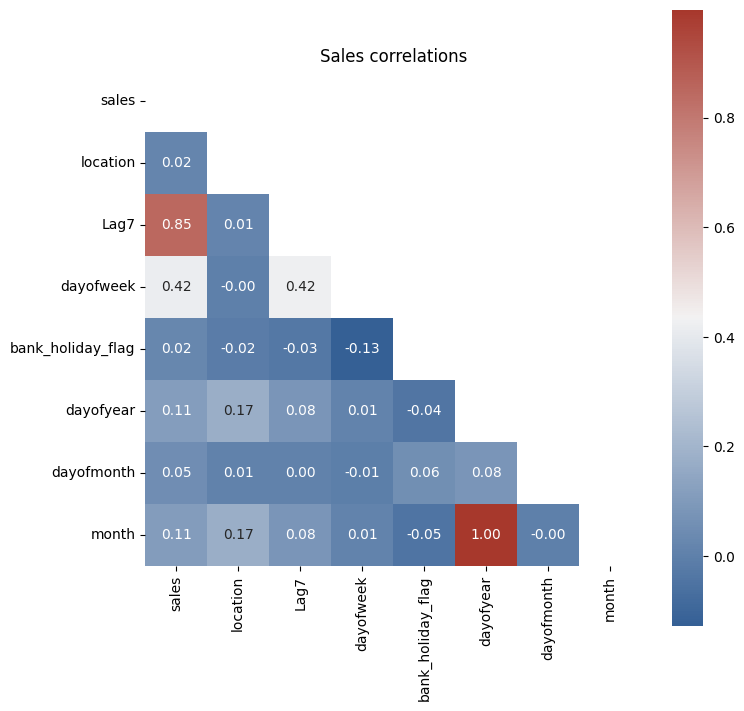

In [37]:
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True)
df_sample1 = df_subset.dropna()
df_sample1 = df_sample1[["sales", "location", "Lag7", "dayofweek", 'bank_holiday_flag', "dayofyear", "dayofmonth", 'month']]# Compute corr matrix
matrix = df_sample1.corr(method="pearson")
# Create a mask
mask = np.triu(np.ones_like(matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(matrix, mask=mask, cmap=cmap, square=True, annot=True, fmt=".2f", ax=ax).set(title='Sales correlations')
plt.show();

Let's check how closely does Lag7 resemble our label in sales:

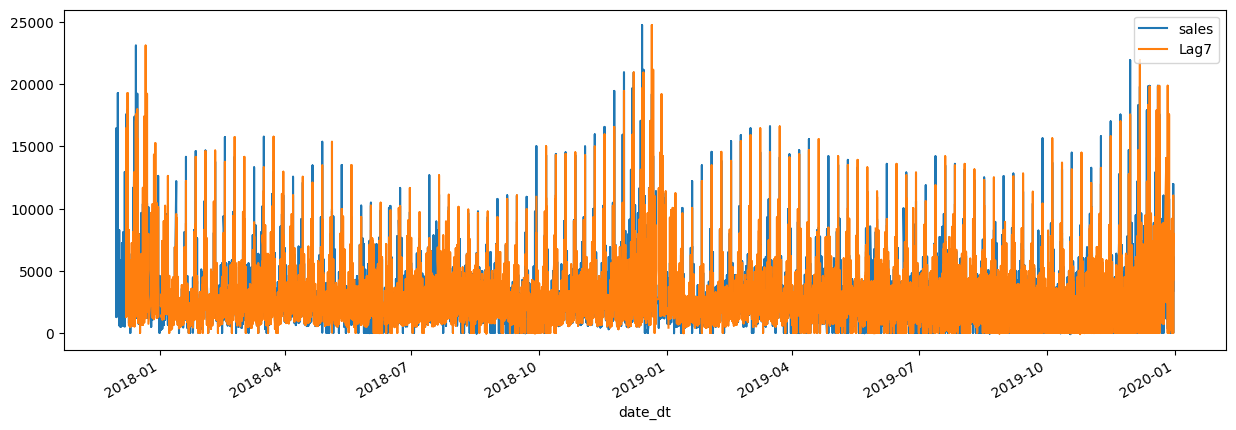

In [39]:
df_viz = df.set_index("date_dt")
_ = df_viz[['sales', 'Lag7']].plot(figsize=(15, 5))

The correlation table indicates, that there is a strong relationship between Lag7 and sales. Month and dayofyear have a correlation of 1 and dayofyear has a slightly higher correlation with sales therefore we discard month from future consideration.

Features Selection

We choose to use the same time of the year (December, 2018), as the validation set, as the data has shown considerable seasonality.

In [40]:
df_train_sub = df.loc[df.date<'2018-12-01'].copy()
df_val = df.loc[(df.date>='2018-12-01')&(df.date<'2019-01-01')].copy()

Due to the correlation shown both dayoftheweek, Lag7 are very important. In addition, we are going to consider the location as it is a key covariate differentiating between different data sources.

In [41]:
base_feature_set = ["location", "Lag7", "dayofweek"]
additional_features = ['dayofmonth', 'dayofyear', 'bank_holiday_flag']

In [42]:
X_train = df_train_sub[base_feature_set]
y_train = df_train_sub['sales']
X_val = df_val[base_feature_set]
y_val = df_val['sales']

In [43]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
       # early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [44]:
df_val['Sales_Prediction'] = reg.predict(X_val)

#without vacation and lag
print(mean_squared_error(y_true=df_val['sales'],
                   y_pred=df_val['Sales_Prediction']))
print(mean_absolute_error(y_true=df_val['sales'],
                   y_pred=df_val['Sales_Prediction']))

2503071.0717222984
969.1134091641146


In [45]:
X_train.head()

,location,Lag7,dayofweek
0,9708,NaN,4
1,9708,NaN,5
2,9708,NaN,6
3,9708,NaN,0
4,9708,NaN,1


In [46]:
for feature in additional_features:
  used_features = base_feature_set + [feature]
  X_train = df_train_sub[used_features]
  y_train = df_train_sub['sales']
  X_val = df_val[used_features]
  y_val = df_val['sales']
  reg = xgb.XGBRegressor(n_estimators=1000)
  reg.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_val, y_val)],
        # early_stopping_rounds=50,
        verbose=False) # Change verbose to True if you want to see it train
  df_val['Sales_Prediction'] = reg.predict(X_val)
  print("For features: " + str(used_features))
  #without vacation and lag
  print(mean_squared_error(y_true=df_val['sales'],
                    y_pred=df_val['Sales_Prediction']))
  print(mean_absolute_error(y_true=df_val['sales'],
                    y_pred=df_val['Sales_Prediction']))

For features: ['location', 'Lag7', 'dayofweek', 'dayofmonth']
3337048.8484488856
1142.7505082952234
For features: ['location', 'Lag7', 'dayofweek', 'dayofyear']
1625644.1523066428
796.5967621098828
For features: ['location', 'Lag7', 'dayofweek', 'bank_holiday_flag']
2436967.308834393
968.70690989302


Therefore ['location', 'Lag7', 'dayofweek', 'dayofyear'] performs best.

In [47]:
X_train = df_train_sub[['location', 'Lag7', 'dayofyear']]
y_train = df_train_sub['sales']
X_val = df_val[['location', 'Lag7', 'dayofyear']]
y_val = df_val['sales']
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
      # early_stopping_rounds=50,
      verbose=False) # Change verbose to True if you want to see it train
df_val['Sales_Prediction'] = reg.predict(X_val)
print("For features: " + str(['location', 'Lag7', 'dayofyear']))
#without vacation and lag
print(mean_squared_error(y_true=df_val['sales'],
                  y_pred=df_val['Sales_Prediction']))
print(mean_absolute_error(y_true=df_val['sales'],
                  y_pred=df_val['Sales_Prediction']))


For features: ['location', 'Lag7', 'dayofyear']
1244371.2261833085
741.1577740637593


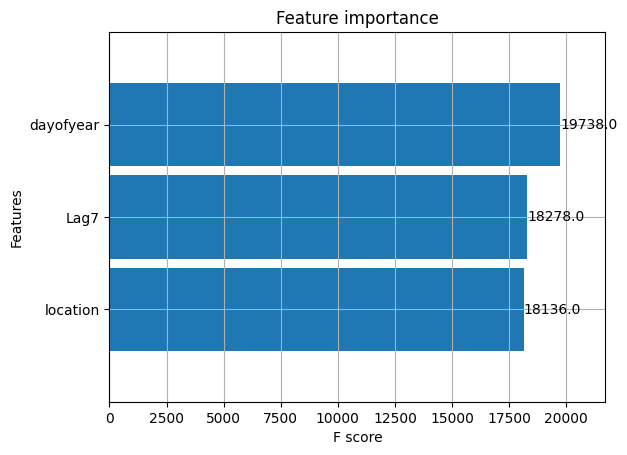

In [48]:
_ = plot_importance(reg, height=0.9)

Hyperparameter tuning

Lets now check for the best hyperparameters using a time series cross validation and grid search:

In [49]:
learning_rates = [0.1, 0.2, 0.15, 0.01]
max_depth_values = [3, 4, 5, 6]
import itertools
configurations = []
for lr,max_depth in itertools.product(learning_rates,max_depth_values):
  configurations.append({'learning_rate':lr, 'max_depth':max_depth})

In [50]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
#configurations = [{'learning_rate':0.10, 'max_depth':5}]

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
errors_final = []
for comp in configurations:
  errors = []
  for train_index, valid_index in tscv.split(df_train):
    train, valid = df_train.iloc[train_index], df_train.iloc[valid_index]
    X_train = train[['location', 'Lag7', 'dayofyear']]
    Y_train = train['sales']
    X_valid = valid[['location', 'Lag7', 'dayofyear']]
    Y_valid = valid['sales']
    model = xgb.XGBRegressor(n_estimators=100, objective='reg:squarederror', random_state=42, learning_rate=comp['learning_rate'], colsample_bytree=0.8, subsample=0.7, max_depth=comp['max_depth'], early_stopping_rounds=50, verbose=True)
    model.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_valid, Y_valid)], verbose=True)
    forecasts = model.predict(X_valid)
    errors.append(mean_squared_error(valid['sales'], forecasts))
    mse_d = {'MSE_average': sum(errors) / len(errors)}
  errors_final.append({**comp, **mse_d})
df_final = pd.DataFrame(errors_final)

[0]	validation_0-rmse:1701.31543	validation_1-rmse:1937.15712
[1]	validation_0-rmse:1581.39626	validation_1-rmse:1808.36725
[2]	validation_0-rmse:1477.76144	validation_1-rmse:1696.67165
[3]	validation_0-rmse:1441.24736	validation_1-rmse:1699.40009
[4]	validation_0-rmse:1354.91732	validation_1-rmse:1604.92388
[5]	validation_0-rmse:1279.22443	validation_1-rmse:1521.83312
[6]	validation_0-rmse:1214.06797	validation_1-rmse:1449.30369
[7]	validation_0-rmse:1158.09034	validation_1-rmse:1386.91217
[8]	validation_0-rmse:1110.43851	validation_1-rmse:1332.69280
[9]	validation_0-rmse:1070.06116	validation_1-rmse:1286.57782
[10]	validation_0-rmse:1033.50459	validation_1-rmse:1244.03509
[11]	validation_0-rmse:1003.64600	validation_1-rmse:1208.84470
[12]	validation_0-rmse:977.94328	validation_1-rmse:1178.30855
[13]	validation_0-rmse:968.45364	validation_1-rmse:1176.49295
[14]	validation_0-rmse:961.16319	validation_1-rmse:1175.39544
[15]	validation_0-rmse:940.35878	validation_1-rmse:1148.76261
[16]	v

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:00:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[17]	validation_0-rmse:917.40566	validation_1-rmse:1126.04488
[18]	validation_0-rmse:902.85601	validation_1-rmse:1105.40741
[19]	validation_0-rmse:891.35759	validation_1-rmse:1106.62180
[20]	validation_0-rmse:881.16559	validation_1-rmse:1090.32922
[21]	validation_0-rmse:872.69983	validation_1-rmse:1077.42318
[22]	validation_0-rmse:868.83033	validation_1-rmse:1076.31967
[23]	validation_0-rmse:861.64823	validation_1-rmse:1064.75760
[24]	validation_0-rmse:856.23383	validation_1-rmse:1062.49202
[25]	validation_0-rmse:851.56740	validation_1-rmse:1061.48460
[26]	validation_0-rmse:848.41820	validation_1-rmse:1060.11786
[27]	validation_0-rmse:843.53849	validation_1-rmse:1051.31431
[28]	validation_0-rmse:841.23861	validation_1-rmse:1049.92837
[29]	validation_0-rmse:838.15921	validation_1-rmse:1043.53656
[30]	validation_0-rmse:835.36881	validation_1-rmse:1039.73020
[31]	validation_0-rmse:834.03052	validation_1-rmse:1038.27349
[32]	validation_0-rmse:831.48480	validation_1-rmse:1035.42764
[33]	val

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:00:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[17]	validation_0-rmse:984.57680	validation_1-rmse:1168.54103
[18]	validation_0-rmse:967.64189	validation_1-rmse:1150.25119
[19]	validation_0-rmse:954.24586	validation_1-rmse:1136.42302
[20]	validation_0-rmse:941.98432	validation_1-rmse:1124.04206
[21]	validation_0-rmse:932.17276	validation_1-rmse:1111.72152
[22]	validation_0-rmse:929.94482	validation_1-rmse:1109.94377
[23]	validation_0-rmse:921.23153	validation_1-rmse:1101.40960
[24]	validation_0-rmse:914.48027	validation_1-rmse:1098.27298
[25]	validation_0-rmse:908.89215	validation_1-rmse:1092.49132
[26]	validation_0-rmse:907.32239	validation_1-rmse:1090.14869
[27]	validation_0-rmse:901.95427	validation_1-rmse:1084.26202
[28]	validation_0-rmse:900.17040	validation_1-rmse:1082.57138
[29]	validation_0-rmse:896.27979	validation_1-rmse:1079.38918
[30]	validation_0-rmse:892.95713	validation_1-rmse:1075.81428
[31]	validation_0-rmse:891.82610	validation_1-rmse:1074.20365
[32]	validation_0-rmse:889.14839	validation_1-rmse:1071.15365
[33]	val

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:00:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[13]	validation_0-rmse:1098.63786	validation_1-rmse:720.49089
[14]	validation_0-rmse:1094.85596	validation_1-rmse:719.29085
[15]	validation_0-rmse:1070.17438	validation_1-rmse:708.13918
[16]	validation_0-rmse:1067.53402	validation_1-rmse:707.64673
[17]	validation_0-rmse:1046.67274	validation_1-rmse:698.19807
[18]	validation_0-rmse:1029.11578	validation_1-rmse:689.62601
[19]	validation_0-rmse:1015.06367	validation_1-rmse:682.36538
[20]	validation_0-rmse:1002.36244	validation_1-rmse:676.96761
[21]	validation_0-rmse:992.01746	validation_1-rmse:672.31374
[22]	validation_0-rmse:990.26027	validation_1-rmse:671.69473
[23]	validation_0-rmse:980.33347	validation_1-rmse:667.76539
[24]	validation_0-rmse:973.22702	validation_1-rmse:664.84012
[25]	validation_0-rmse:967.22644	validation_1-rmse:662.27041
[26]	validation_0-rmse:965.86885	validation_1-rmse:661.97446
[27]	validation_0-rmse:959.98802	validation_1-rmse:659.28300
[28]	validation_0-rmse:958.79396	validation_1-rmse:659.43868
[29]	validation_

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:01:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[14]	validation_0-rmse:1018.38951	validation_1-rmse:789.49813
[15]	validation_0-rmse:996.11910	validation_1-rmse:775.14118
[16]	validation_0-rmse:993.37378	validation_1-rmse:774.14339
[17]	validation_0-rmse:974.83401	validation_1-rmse:761.76979
[18]	validation_0-rmse:959.42188	validation_1-rmse:751.64868
[19]	validation_0-rmse:947.20071	validation_1-rmse:744.89304
[20]	validation_0-rmse:935.81208	validation_1-rmse:737.81070
[21]	validation_0-rmse:926.31375	validation_1-rmse:731.83516
[22]	validation_0-rmse:925.00473	validation_1-rmse:730.95587
[23]	validation_0-rmse:916.70688	validation_1-rmse:726.01905
[24]	validation_0-rmse:910.27257	validation_1-rmse:722.24384
[25]	validation_0-rmse:904.93336	validation_1-rmse:718.74849
[26]	validation_0-rmse:903.90562	validation_1-rmse:718.17242
[27]	validation_0-rmse:897.71288	validation_1-rmse:715.33837
[28]	validation_0-rmse:896.87584	validation_1-rmse:715.18038
[29]	validation_0-rmse:893.16746	validation_1-rmse:712.57156
[30]	validation_0-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:01:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[9]	validation_0-rmse:1068.75807	validation_1-rmse:875.23669
[10]	validation_0-rmse:1035.81759	validation_1-rmse:850.99976
[11]	validation_0-rmse:1007.81770	validation_1-rmse:830.58670
[12]	validation_0-rmse:983.77815	validation_1-rmse:813.68087
[13]	validation_0-rmse:980.19517	validation_1-rmse:811.82600
[14]	validation_0-rmse:977.15533	validation_1-rmse:810.39615
[15]	validation_0-rmse:956.78649	validation_1-rmse:796.14022
[16]	validation_0-rmse:954.22255	validation_1-rmse:795.05390
[17]	validation_0-rmse:937.06568	validation_1-rmse:782.47078
[18]	validation_0-rmse:923.16237	validation_1-rmse:772.60153
[19]	validation_0-rmse:911.58523	validation_1-rmse:764.73936
[20]	validation_0-rmse:901.11442	validation_1-rmse:757.43499
[21]	validation_0-rmse:892.77452	validation_1-rmse:752.14108
[22]	validation_0-rmse:891.48547	validation_1-rmse:751.22785
[23]	validation_0-rmse:883.41849	validation_1-rmse:745.95696
[24]	validation_0-rmse:877.58272	validation_1-rmse:742.70898
[25]	validation_0-rmse

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:01:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[3]	validation_0-rmse:1419.10453	validation_1-rmse:1716.49884
[4]	validation_0-rmse:1331.21567	validation_1-rmse:1620.48559
[5]	validation_0-rmse:1255.49078	validation_1-rmse:1553.28550
[6]	validation_0-rmse:1188.83484	validation_1-rmse:1477.03832
[7]	validation_0-rmse:1132.66990	validation_1-rmse:1420.86197
[8]	validation_0-rmse:1084.40808	validation_1-rmse:1379.14669
[9]	validation_0-rmse:1042.48393	validation_1-rmse:1328.03107
[10]	validation_0-rmse:1004.84779	validation_1-rmse:1281.88995
[11]	validation_0-rmse:973.63516	validation_1-rmse:1243.25355
[12]	validation_0-rmse:947.69159	validation_1-rmse:1209.82261
[13]	validation_0-rmse:937.53260	validation_1-rmse:1209.52232
[14]	validation_0-rmse:928.10829	validation_1-rmse:1209.55075
[15]	validation_0-rmse:908.21844	validation_1-rmse:1180.87257
[16]	validation_0-rmse:901.76959	validation_1-rmse:1180.77836
[17]	validation_0-rmse:885.45608	validation_1-rmse:1156.98069
[18]	validation_0-rmse:871.87915	validation_1-rmse:1136.24687
[19]	va

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:01:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[21]	validation_0-rmse:899.09156	validation_1-rmse:1094.89036
[22]	validation_0-rmse:896.48907	validation_1-rmse:1092.85176
[23]	validation_0-rmse:888.29524	validation_1-rmse:1083.89644
[24]	validation_0-rmse:882.08187	validation_1-rmse:1076.73808
[25]	validation_0-rmse:877.09127	validation_1-rmse:1074.32840
[26]	validation_0-rmse:874.48013	validation_1-rmse:1072.53183
[27]	validation_0-rmse:869.02941	validation_1-rmse:1065.53851
[28]	validation_0-rmse:866.91237	validation_1-rmse:1063.68724
[29]	validation_0-rmse:863.36031	validation_1-rmse:1060.89088
[30]	validation_0-rmse:860.41358	validation_1-rmse:1059.84979
[31]	validation_0-rmse:859.03095	validation_1-rmse:1058.51120
[32]	validation_0-rmse:856.51642	validation_1-rmse:1059.78711
[33]	validation_0-rmse:855.74860	validation_1-rmse:1058.93152
[34]	validation_0-rmse:853.68998	validation_1-rmse:1055.73402
[35]	validation_0-rmse:851.72960	validation_1-rmse:1056.03460
[36]	validation_0-rmse:850.10574	validation_1-rmse:1055.27606
[37]	val

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:01:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	validation_0-rmse:1424.26111	validation_1-rmse:886.86750
[6]	validation_0-rmse:1347.97347	validation_1-rmse:846.45376
[7]	validation_0-rmse:1283.92616	validation_1-rmse:812.75050
[8]	validation_0-rmse:1229.61974	validation_1-rmse:784.18873
[9]	validation_0-rmse:1181.29239	validation_1-rmse:760.60187
[10]	validation_0-rmse:1139.38325	validation_1-rmse:739.70558
[11]	validation_0-rmse:1104.43373	validation_1-rmse:722.69299
[12]	validation_0-rmse:1074.63775	validation_1-rmse:709.29786
[13]	validation_0-rmse:1069.58690	validation_1-rmse:707.36614
[14]	validation_0-rmse:1065.35054	validation_1-rmse:707.41601
[15]	validation_0-rmse:1040.62866	validation_1-rmse:696.03826
[16]	validation_0-rmse:1037.17296	validation_1-rmse:695.70281
[17]	validation_0-rmse:1016.28651	validation_1-rmse:686.51272
[18]	validation_0-rmse:999.06793	validation_1-rmse:678.94094
[19]	validation_0-rmse:986.05105	validation_1-rmse:672.75355
[20]	validation_0-rmse:973.18661	validation_1-rmse:668.09965
[21]	validation_

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:01:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	validation_0-rmse:1243.55407	validation_1-rmse:942.10896
[7]	validation_0-rmse:1185.79554	validation_1-rmse:903.21806
[8]	validation_0-rmse:1136.89052	validation_1-rmse:870.28526
[9]	validation_0-rmse:1093.80083	validation_1-rmse:841.85044
[10]	validation_0-rmse:1056.93858	validation_1-rmse:817.46260
[11]	validation_0-rmse:1025.96991	validation_1-rmse:797.39523
[12]	validation_0-rmse:999.95350	validation_1-rmse:780.95143
[13]	validation_0-rmse:996.32230	validation_1-rmse:779.08631
[14]	validation_0-rmse:992.81300	validation_1-rmse:778.31009
[15]	validation_0-rmse:970.79926	validation_1-rmse:764.42213
[16]	validation_0-rmse:968.34110	validation_1-rmse:763.19520
[17]	validation_0-rmse:949.39213	validation_1-rmse:751.98345
[18]	validation_0-rmse:933.91941	validation_1-rmse:742.79452
[19]	validation_0-rmse:922.28463	validation_1-rmse:735.61235
[20]	validation_0-rmse:910.78100	validation_1-rmse:728.53300
[21]	validation_0-rmse:901.59767	validation_1-rmse:723.49486
[22]	validation_0-rmse

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:01:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	validation_0-rmse:1252.34023	validation_1-rmse:1013.70351
[6]	validation_0-rmse:1188.21029	validation_1-rmse:967.50356
[7]	validation_0-rmse:1134.25549	validation_1-rmse:928.27339
[8]	validation_0-rmse:1088.65542	validation_1-rmse:894.77239
[9]	validation_0-rmse:1048.44375	validation_1-rmse:866.01062
[10]	validation_0-rmse:1014.29785	validation_1-rmse:841.40944
[11]	validation_0-rmse:985.63563	validation_1-rmse:821.19504
[12]	validation_0-rmse:961.53079	validation_1-rmse:803.90025
[13]	validation_0-rmse:957.63468	validation_1-rmse:801.72586
[14]	validation_0-rmse:954.08594	validation_1-rmse:800.32692
[15]	validation_0-rmse:933.58616	validation_1-rmse:785.90069
[16]	validation_0-rmse:931.05157	validation_1-rmse:784.87804
[17]	validation_0-rmse:913.56235	validation_1-rmse:772.92959
[18]	validation_0-rmse:899.25925	validation_1-rmse:763.16296
[19]	validation_0-rmse:888.51073	validation_1-rmse:755.81279
[20]	validation_0-rmse:878.24392	validation_1-rmse:748.95352
[21]	validation_0-rmse

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:02:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[14]	validation_0-rmse:905.52502	validation_1-rmse:1254.26219
[15]	validation_0-rmse:885.28700	validation_1-rmse:1224.28107
[16]	validation_0-rmse:877.54282	validation_1-rmse:1224.48797
[17]	validation_0-rmse:860.63911	validation_1-rmse:1198.66467
[18]	validation_0-rmse:847.07969	validation_1-rmse:1176.85080
[19]	validation_0-rmse:836.61876	validation_1-rmse:1172.98070
[20]	validation_0-rmse:826.76651	validation_1-rmse:1156.73052
[21]	validation_0-rmse:818.03676	validation_1-rmse:1140.83020
[22]	validation_0-rmse:814.57277	validation_1-rmse:1140.75903
[23]	validation_0-rmse:807.38575	validation_1-rmse:1127.03684
[24]	validation_0-rmse:801.81087	validation_1-rmse:1125.23181
[25]	validation_0-rmse:797.12524	validation_1-rmse:1121.68363
[26]	validation_0-rmse:793.79201	validation_1-rmse:1120.46452
[27]	validation_0-rmse:788.92240	validation_1-rmse:1110.27772
[28]	validation_0-rmse:785.41793	validation_1-rmse:1108.67292
[29]	validation_0-rmse:782.26843	validation_1-rmse:1101.87631
[30]	val

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:02:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[4]	validation_0-rmse:1417.89305	validation_1-rmse:1662.77835
[5]	validation_0-rmse:1334.91569	validation_1-rmse:1581.42170
[6]	validation_0-rmse:1259.23841	validation_1-rmse:1499.91713
[7]	validation_0-rmse:1198.07704	validation_1-rmse:1433.03574
[8]	validation_0-rmse:1145.99676	validation_1-rmse:1381.46202
[9]	validation_0-rmse:1098.01760	validation_1-rmse:1329.03601
[10]	validation_0-rmse:1056.37126	validation_1-rmse:1282.70712
[11]	validation_0-rmse:1019.66223	validation_1-rmse:1240.57471
[12]	validation_0-rmse:989.95160	validation_1-rmse:1205.75168
[13]	validation_0-rmse:980.24716	validation_1-rmse:1205.56421
[14]	validation_0-rmse:972.16784	validation_1-rmse:1205.86066
[15]	validation_0-rmse:948.86415	validation_1-rmse:1177.91000
[16]	validation_0-rmse:942.92819	validation_1-rmse:1177.23398
[17]	validation_0-rmse:922.92003	validation_1-rmse:1153.87796
[18]	validation_0-rmse:906.59835	validation_1-rmse:1134.73178
[19]	validation_0-rmse:894.68254	validation_1-rmse:1120.33205
[20]	v

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:02:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[8]	validation_0-rmse:1217.03894	validation_1-rmse:784.44135
[9]	validation_0-rmse:1166.60563	validation_1-rmse:759.69871
[10]	validation_0-rmse:1123.49160	validation_1-rmse:739.21750
[11]	validation_0-rmse:1087.26448	validation_1-rmse:721.88995
[12]	validation_0-rmse:1056.10231	validation_1-rmse:707.84791
[13]	validation_0-rmse:1049.84205	validation_1-rmse:706.99319
[14]	validation_0-rmse:1044.24066	validation_1-rmse:708.12272
[15]	validation_0-rmse:1019.05304	validation_1-rmse:696.31479
[16]	validation_0-rmse:1015.30204	validation_1-rmse:696.33301
[17]	validation_0-rmse:994.01383	validation_1-rmse:686.67656
[18]	validation_0-rmse:976.44946	validation_1-rmse:678.91153
[19]	validation_0-rmse:963.63679	validation_1-rmse:672.95105
[20]	validation_0-rmse:950.35508	validation_1-rmse:667.34180
[21]	validation_0-rmse:939.08445	validation_1-rmse:662.51840
[22]	validation_0-rmse:936.17019	validation_1-rmse:661.36434
[23]	validation_0-rmse:927.21565	validation_1-rmse:657.27652
[24]	validation_0

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:02:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[7]	validation_0-rmse:1172.70294	validation_1-rmse:904.01124
[8]	validation_0-rmse:1124.11350	validation_1-rmse:871.96738
[9]	validation_0-rmse:1079.44709	validation_1-rmse:842.84668
[10]	validation_0-rmse:1041.50893	validation_1-rmse:818.51640
[11]	validation_0-rmse:1009.15189	validation_1-rmse:797.94790
[12]	validation_0-rmse:982.16825	validation_1-rmse:781.16360
[13]	validation_0-rmse:977.58399	validation_1-rmse:779.78739
[14]	validation_0-rmse:973.49942	validation_1-rmse:778.57499
[15]	validation_0-rmse:951.29658	validation_1-rmse:764.88069
[16]	validation_0-rmse:947.97378	validation_1-rmse:766.03363
[17]	validation_0-rmse:929.07284	validation_1-rmse:754.58546
[18]	validation_0-rmse:913.76629	validation_1-rmse:745.14401
[19]	validation_0-rmse:902.37398	validation_1-rmse:738.25705
[20]	validation_0-rmse:890.83314	validation_1-rmse:731.23529
[21]	validation_0-rmse:881.37149	validation_1-rmse:725.40045
[22]	validation_0-rmse:879.00669	validation_1-rmse:723.86593
[23]	validation_0-rmse

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:02:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[11]	validation_0-rmse:970.62702	validation_1-rmse:815.56355
[12]	validation_0-rmse:945.06874	validation_1-rmse:798.32110
[13]	validation_0-rmse:940.70534	validation_1-rmse:796.10924
[14]	validation_0-rmse:935.75410	validation_1-rmse:794.43870
[15]	validation_0-rmse:914.97782	validation_1-rmse:780.16513
[16]	validation_0-rmse:911.64890	validation_1-rmse:779.31287
[17]	validation_0-rmse:894.67327	validation_1-rmse:767.40767
[18]	validation_0-rmse:880.34272	validation_1-rmse:757.64316
[19]	validation_0-rmse:869.78835	validation_1-rmse:750.71315
[20]	validation_0-rmse:859.25283	validation_1-rmse:743.97185
[21]	validation_0-rmse:850.46586	validation_1-rmse:738.34521
[22]	validation_0-rmse:848.54294	validation_1-rmse:737.30632
[23]	validation_0-rmse:841.29394	validation_1-rmse:732.67702
[24]	validation_0-rmse:835.94661	validation_1-rmse:729.20764
[25]	validation_0-rmse:831.56390	validation_1-rmse:726.86768
[26]	validation_0-rmse:830.26520	validation_1-rmse:726.19460
[27]	validation_0-rmse:8

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:03:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[14]	validation_0-rmse:888.25607	validation_1-rmse:1267.49068
[15]	validation_0-rmse:866.24789	validation_1-rmse:1237.05002
[16]	validation_0-rmse:857.98427	validation_1-rmse:1237.20252
[17]	validation_0-rmse:839.58830	validation_1-rmse:1210.06446
[18]	validation_0-rmse:825.15638	validation_1-rmse:1188.48948
[19]	validation_0-rmse:813.62091	validation_1-rmse:1185.87530
[20]	validation_0-rmse:802.88552	validation_1-rmse:1168.30195
[21]	validation_0-rmse:793.32565	validation_1-rmse:1152.58481
[22]	validation_0-rmse:788.63133	validation_1-rmse:1151.63363
[23]	validation_0-rmse:780.70650	validation_1-rmse:1137.81640
[24]	validation_0-rmse:774.58940	validation_1-rmse:1137.41741
[25]	validation_0-rmse:769.47409	validation_1-rmse:1133.43699
[26]	validation_0-rmse:765.71646	validation_1-rmse:1131.80412
[27]	validation_0-rmse:760.36842	validation_1-rmse:1121.48953
[28]	validation_0-rmse:756.66597	validation_1-rmse:1119.78012
[29]	validation_0-rmse:752.97757	validation_1-rmse:1117.15040
[30]	val

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:03:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[8]	validation_0-rmse:1131.30093	validation_1-rmse:1399.91560
[9]	validation_0-rmse:1082.27280	validation_1-rmse:1344.82720
[10]	validation_0-rmse:1039.84772	validation_1-rmse:1296.86329
[11]	validation_0-rmse:1002.45791	validation_1-rmse:1253.09026
[12]	validation_0-rmse:972.37080	validation_1-rmse:1216.06339
[13]	validation_0-rmse:960.90000	validation_1-rmse:1215.97526
[14]	validation_0-rmse:951.28463	validation_1-rmse:1215.93574
[15]	validation_0-rmse:927.69269	validation_1-rmse:1187.76268
[16]	validation_0-rmse:920.76129	validation_1-rmse:1187.77501
[17]	validation_0-rmse:900.53753	validation_1-rmse:1162.53150
[18]	validation_0-rmse:884.01192	validation_1-rmse:1141.80732
[19]	validation_0-rmse:871.50857	validation_1-rmse:1126.63298
[20]	validation_0-rmse:859.31192	validation_1-rmse:1111.27285
[21]	validation_0-rmse:849.11580	validation_1-rmse:1096.89456
[22]	validation_0-rmse:846.05696	validation_1-rmse:1096.32031
[23]	validation_0-rmse:837.66423	validation_1-rmse:1084.89940
[24]	v

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:03:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[12]	validation_0-rmse:1040.78950	validation_1-rmse:704.13599
[13]	validation_0-rmse:1033.10466	validation_1-rmse:704.05902
[14]	validation_0-rmse:1027.10300	validation_1-rmse:705.49348
[15]	validation_0-rmse:1001.67999	validation_1-rmse:693.95173
[16]	validation_0-rmse:994.88338	validation_1-rmse:696.94831
[17]	validation_0-rmse:973.31388	validation_1-rmse:687.15470
[18]	validation_0-rmse:954.84701	validation_1-rmse:678.74956
[19]	validation_0-rmse:941.82244	validation_1-rmse:672.78103
[20]	validation_0-rmse:928.09726	validation_1-rmse:666.80646
[21]	validation_0-rmse:917.12009	validation_1-rmse:662.18971
[22]	validation_0-rmse:913.71639	validation_1-rmse:661.39671
[23]	validation_0-rmse:904.17111	validation_1-rmse:657.22736
[24]	validation_0-rmse:897.44587	validation_1-rmse:654.76267
[25]	validation_0-rmse:891.73950	validation_1-rmse:652.55969
[26]	validation_0-rmse:888.60405	validation_1-rmse:653.17480
[27]	validation_0-rmse:882.23083	validation_1-rmse:651.07844
[28]	validation_0-rm

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:03:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[4]	validation_0-rmse:1369.24094	validation_1-rmse:1040.31868
[5]	validation_0-rmse:1291.26929	validation_1-rmse:987.94390
[6]	validation_0-rmse:1220.55876	validation_1-rmse:941.44504
[7]	validation_0-rmse:1163.25471	validation_1-rmse:903.61057
[8]	validation_0-rmse:1114.58439	validation_1-rmse:871.61132
[9]	validation_0-rmse:1068.96546	validation_1-rmse:842.35121
[10]	validation_0-rmse:1029.99894	validation_1-rmse:817.74991
[11]	validation_0-rmse:996.97321	validation_1-rmse:796.99719
[12]	validation_0-rmse:969.06743	validation_1-rmse:779.62899
[13]	validation_0-rmse:962.14932	validation_1-rmse:782.77421
[14]	validation_0-rmse:957.21700	validation_1-rmse:781.54495
[15]	validation_0-rmse:934.10806	validation_1-rmse:767.14029
[16]	validation_0-rmse:929.33678	validation_1-rmse:772.26386
[17]	validation_0-rmse:910.35478	validation_1-rmse:760.80678
[18]	validation_0-rmse:895.13714	validation_1-rmse:751.15713
[19]	validation_0-rmse:883.45923	validation_1-rmse:743.99413
[20]	validation_0-rmse

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:03:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:1630.49964	validation_1-rmse:1285.47382
[1]	validation_0-rmse:1515.95557	validation_1-rmse:1202.34305
[2]	validation_0-rmse:1415.59433	validation_1-rmse:1129.62452
[3]	validation_0-rmse:1399.06085	validation_1-rmse:1121.99826
[4]	validation_0-rmse:1310.12276	validation_1-rmse:1056.92184
[5]	validation_0-rmse:1236.61315	validation_1-rmse:1004.81582
[6]	validation_0-rmse:1169.62748	validation_1-rmse:957.03755
[7]	validation_0-rmse:1115.47699	validation_1-rmse:918.31983
[8]	validation_0-rmse:1069.70596	validation_1-rmse:886.07459
[9]	validation_0-rmse:1027.33073	validation_1-rmse:857.18231
[10]	validation_0-rmse:990.59534	validation_1-rmse:831.77383
[11]	validation_0-rmse:959.74270	validation_1-rmse:811.33561
[12]	validation_0-rmse:933.77932	validation_1-rmse:793.64082
[13]	validation_0-rmse:928.27362	validation_1-rmse:791.23614
[14]	validation_0-rmse:923.38938	validation_1-rmse:788.87770
[15]	validation_0-rmse:901.74271	validation_1-rmse:775.00893
[16]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:03:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[13]	validation_0-rmse:843.68950	validation_1-rmse:1039.07172
[14]	validation_0-rmse:839.32204	validation_1-rmse:1036.20512
[15]	validation_0-rmse:833.49311	validation_1-rmse:1020.30668
[16]	validation_0-rmse:830.52335	validation_1-rmse:1018.23397
[17]	validation_0-rmse:825.63943	validation_1-rmse:1011.79392
[18]	validation_0-rmse:821.90780	validation_1-rmse:1004.24840
[19]	validation_0-rmse:818.85124	validation_1-rmse:1018.18061
[20]	validation_0-rmse:815.05675	validation_1-rmse:1007.94128
[21]	validation_0-rmse:812.77076	validation_1-rmse:1001.99096
[22]	validation_0-rmse:811.43290	validation_1-rmse:1001.30374
[23]	validation_0-rmse:809.04934	validation_1-rmse:995.84273
[24]	validation_0-rmse:806.88151	validation_1-rmse:993.49579
[25]	validation_0-rmse:805.68264	validation_1-rmse:993.77586
[26]	validation_0-rmse:804.50398	validation_1-rmse:992.23946
[27]	validation_0-rmse:803.80239	validation_1-rmse:990.67472
[28]	validation_0-rmse:802.53106	validation_1-rmse:990.02351
[29]	validatio

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:03:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	validation_0-rmse:1049.52507	validation_1-rmse:1252.53187
[7]	validation_0-rmse:1003.42211	validation_1-rmse:1198.63110
[8]	validation_0-rmse:972.17745	validation_1-rmse:1166.05693
[9]	validation_0-rmse:946.89645	validation_1-rmse:1136.63230
[10]	validation_0-rmse:926.91592	validation_1-rmse:1109.94769
[11]	validation_0-rmse:912.57395	validation_1-rmse:1092.36614
[12]	validation_0-rmse:901.54780	validation_1-rmse:1076.55499
[13]	validation_0-rmse:897.42749	validation_1-rmse:1070.92269
[14]	validation_0-rmse:894.18474	validation_1-rmse:1067.26434
[15]	validation_0-rmse:885.15127	validation_1-rmse:1059.56048
[16]	validation_0-rmse:883.11006	validation_1-rmse:1057.26761
[17]	validation_0-rmse:876.48840	validation_1-rmse:1048.04806
[18]	validation_0-rmse:871.60595	validation_1-rmse:1040.04130
[19]	validation_0-rmse:868.25612	validation_1-rmse:1036.64120
[20]	validation_0-rmse:865.08983	validation_1-rmse:1032.81714
[21]	validation_0-rmse:861.68548	validation_1-rmse:1030.15578
[22]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:04:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[8]	validation_0-rmse:1028.38747	validation_1-rmse:688.99912
[9]	validation_0-rmse:1001.95012	validation_1-rmse:677.63426
[10]	validation_0-rmse:981.36123	validation_1-rmse:669.85514
[11]	validation_0-rmse:966.57904	validation_1-rmse:662.46075
[12]	validation_0-rmse:954.89710	validation_1-rmse:659.59869
[13]	validation_0-rmse:952.33642	validation_1-rmse:657.91388
[14]	validation_0-rmse:948.62272	validation_1-rmse:656.20998
[15]	validation_0-rmse:940.35242	validation_1-rmse:653.53165
[16]	validation_0-rmse:939.27857	validation_1-rmse:653.32581
[17]	validation_0-rmse:932.66805	validation_1-rmse:650.99520
[18]	validation_0-rmse:926.85349	validation_1-rmse:650.00535
[19]	validation_0-rmse:924.22841	validation_1-rmse:648.98075
[20]	validation_0-rmse:920.90960	validation_1-rmse:648.16381
[21]	validation_0-rmse:917.83624	validation_1-rmse:647.12652
[22]	validation_0-rmse:916.11798	validation_1-rmse:645.83918
[23]	validation_0-rmse:913.63703	validation_1-rmse:644.63376
[24]	validation_0-rmse:9

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:04:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	validation_0-rmse:1312.11826	validation_1-rmse:985.16379
[3]	validation_0-rmse:1300.47943	validation_1-rmse:980.16556
[4]	validation_0-rmse:1180.36222	validation_1-rmse:896.09057
[5]	validation_0-rmse:1093.42134	validation_1-rmse:838.55566
[6]	validation_0-rmse:1030.35889	validation_1-rmse:797.83064
[7]	validation_0-rmse:988.26789	validation_1-rmse:771.94467
[8]	validation_0-rmse:959.53502	validation_1-rmse:753.82741
[9]	validation_0-rmse:936.86280	validation_1-rmse:738.16366
[10]	validation_0-rmse:917.89764	validation_1-rmse:727.44489
[11]	validation_0-rmse:904.51824	validation_1-rmse:718.65514
[12]	validation_0-rmse:894.76880	validation_1-rmse:713.80470
[13]	validation_0-rmse:892.72017	validation_1-rmse:712.79437
[14]	validation_0-rmse:891.25114	validation_1-rmse:712.71946
[15]	validation_0-rmse:883.40228	validation_1-rmse:709.47079
[16]	validation_0-rmse:882.32843	validation_1-rmse:708.41193
[17]	validation_0-rmse:876.40023	validation_1-rmse:705.18364
[18]	validation_0-rmse:872.

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:04:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[7]	validation_0-rmse:950.63018	validation_1-rmse:793.16164
[8]	validation_0-rmse:923.53312	validation_1-rmse:773.45908
[9]	validation_0-rmse:902.92195	validation_1-rmse:758.44676
[10]	validation_0-rmse:885.70938	validation_1-rmse:747.06519
[11]	validation_0-rmse:873.37163	validation_1-rmse:740.09080
[12]	validation_0-rmse:864.27950	validation_1-rmse:734.91358
[13]	validation_0-rmse:862.43268	validation_1-rmse:733.91977
[14]	validation_0-rmse:861.00165	validation_1-rmse:732.96388
[15]	validation_0-rmse:853.41565	validation_1-rmse:728.88119
[16]	validation_0-rmse:852.16740	validation_1-rmse:728.16974
[17]	validation_0-rmse:846.66938	validation_1-rmse:724.98556
[18]	validation_0-rmse:842.20355	validation_1-rmse:722.30626
[19]	validation_0-rmse:839.35315	validation_1-rmse:720.64689
[20]	validation_0-rmse:836.84292	validation_1-rmse:719.58733
[21]	validation_0-rmse:834.11252	validation_1-rmse:718.90281
[22]	validation_0-rmse:833.10167	validation_1-rmse:718.47113
[23]	validation_0-rmse:831.

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:04:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[19]	validation_0-rmse:785.27534	validation_1-rmse:1043.13783
[20]	validation_0-rmse:782.31451	validation_1-rmse:1035.91466
[21]	validation_0-rmse:779.56206	validation_1-rmse:1029.72965
[22]	validation_0-rmse:777.08259	validation_1-rmse:1028.25015
[23]	validation_0-rmse:774.60605	validation_1-rmse:1022.95089
[24]	validation_0-rmse:773.06050	validation_1-rmse:1025.54490
[25]	validation_0-rmse:771.01144	validation_1-rmse:1028.10152
[26]	validation_0-rmse:769.88755	validation_1-rmse:1027.49622
[27]	validation_0-rmse:768.20439	validation_1-rmse:1024.39978
[28]	validation_0-rmse:766.47975	validation_1-rmse:1036.70876
[29]	validation_0-rmse:765.29714	validation_1-rmse:1040.01759
[30]	validation_0-rmse:764.82056	validation_1-rmse:1045.76673
[31]	validation_0-rmse:762.62372	validation_1-rmse:1044.76760
[32]	validation_0-rmse:761.79479	validation_1-rmse:1044.29534
[33]	validation_0-rmse:760.85065	validation_1-rmse:1044.28622
[34]	validation_0-rmse:760.13989	validation_1-rmse:1049.88594
[35]	val

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:04:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[8]	validation_0-rmse:941.40015	validation_1-rmse:1159.19308
[9]	validation_0-rmse:916.20090	validation_1-rmse:1125.84016
[10]	validation_0-rmse:896.76137	validation_1-rmse:1102.44098
[11]	validation_0-rmse:882.14349	validation_1-rmse:1081.04697
[12]	validation_0-rmse:871.18267	validation_1-rmse:1062.86559
[13]	validation_0-rmse:866.98480	validation_1-rmse:1059.63293
[14]	validation_0-rmse:863.13105	validation_1-rmse:1057.14210
[15]	validation_0-rmse:855.09920	validation_1-rmse:1048.32891
[16]	validation_0-rmse:852.63327	validation_1-rmse:1045.57019
[17]	validation_0-rmse:846.60729	validation_1-rmse:1038.68999
[18]	validation_0-rmse:842.13490	validation_1-rmse:1031.89506
[19]	validation_0-rmse:839.23799	validation_1-rmse:1029.64196
[20]	validation_0-rmse:836.63075	validation_1-rmse:1026.03361
[21]	validation_0-rmse:832.09590	validation_1-rmse:1021.10036
[22]	validation_0-rmse:827.51358	validation_1-rmse:1020.41577
[23]	validation_0-rmse:824.09303	validation_1-rmse:1016.41658
[24]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:04:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-rmse:1596.88784	validation_1-rmse:981.05159
[2]	validation_0-rmse:1404.97066	validation_1-rmse:878.85073
[3]	validation_0-rmse:1387.19421	validation_1-rmse:875.97354
[4]	validation_0-rmse:1250.37318	validation_1-rmse:802.00715
[5]	validation_0-rmse:1154.28000	validation_1-rmse:752.24890
[6]	validation_0-rmse:1080.82559	validation_1-rmse:717.35685
[7]	validation_0-rmse:1034.30096	validation_1-rmse:694.91359
[8]	validation_0-rmse:1002.74971	validation_1-rmse:679.94129
[9]	validation_0-rmse:975.92879	validation_1-rmse:670.00348
[10]	validation_0-rmse:955.50521	validation_1-rmse:662.90693
[11]	validation_0-rmse:941.50750	validation_1-rmse:658.11053
[12]	validation_0-rmse:931.53847	validation_1-rmse:654.96456
[13]	validation_0-rmse:929.09011	validation_1-rmse:654.99475
[14]	validation_0-rmse:926.31053	validation_1-rmse:654.22717
[15]	validation_0-rmse:917.24763	validation_1-rmse:650.57941
[16]	validation_0-rmse:912.25954	validation_1-rmse:656.04200
[17]	validation_0-rmse:90

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:05:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-rmse:896.68281	validation_1-rmse:716.96216
[11]	validation_0-rmse:884.18921	validation_1-rmse:710.21696
[12]	validation_0-rmse:873.14817	validation_1-rmse:705.84554
[13]	validation_0-rmse:871.09449	validation_1-rmse:704.85312
[14]	validation_0-rmse:868.67484	validation_1-rmse:703.39795
[15]	validation_0-rmse:862.20704	validation_1-rmse:699.97748
[16]	validation_0-rmse:861.19747	validation_1-rmse:699.13640
[17]	validation_0-rmse:855.83969	validation_1-rmse:695.65646
[18]	validation_0-rmse:851.43311	validation_1-rmse:693.58723
[19]	validation_0-rmse:848.70463	validation_1-rmse:692.51720
[20]	validation_0-rmse:845.37181	validation_1-rmse:690.68087
[21]	validation_0-rmse:843.35651	validation_1-rmse:689.55681
[22]	validation_0-rmse:842.77820	validation_1-rmse:689.39242
[23]	validation_0-rmse:839.95962	validation_1-rmse:688.63955
[24]	validation_0-rmse:837.95183	validation_1-rmse:689.21070
[25]	validation_0-rmse:836.76893	validation_1-rmse:689.53293
[26]	validation_0-rmse:8

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:05:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[11]	validation_0-rmse:850.69238	validation_1-rmse:732.87379
[12]	validation_0-rmse:841.03164	validation_1-rmse:728.54511
[13]	validation_0-rmse:838.10349	validation_1-rmse:726.93709
[14]	validation_0-rmse:835.37092	validation_1-rmse:725.12869
[15]	validation_0-rmse:828.49861	validation_1-rmse:721.22674
[16]	validation_0-rmse:826.49397	validation_1-rmse:720.78576
[17]	validation_0-rmse:821.98299	validation_1-rmse:718.50020
[18]	validation_0-rmse:818.46872	validation_1-rmse:716.78392
[19]	validation_0-rmse:816.17454	validation_1-rmse:715.95830
[20]	validation_0-rmse:813.17516	validation_1-rmse:714.71501
[21]	validation_0-rmse:811.09221	validation_1-rmse:713.55557
[22]	validation_0-rmse:810.29418	validation_1-rmse:713.31061
[23]	validation_0-rmse:808.04581	validation_1-rmse:712.65694
[24]	validation_0-rmse:806.44188	validation_1-rmse:712.16151
[25]	validation_0-rmse:805.35063	validation_1-rmse:711.72115
[26]	validation_0-rmse:804.32172	validation_1-rmse:711.23915
[27]	validation_0-rmse:8

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:05:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[8]	validation_0-rmse:856.44195	validation_1-rmse:1251.15433
[9]	validation_0-rmse:833.20656	validation_1-rmse:1212.08065
[10]	validation_0-rmse:813.41319	validation_1-rmse:1175.27021
[11]	validation_0-rmse:799.82730	validation_1-rmse:1146.64560
[12]	validation_0-rmse:789.91843	validation_1-rmse:1127.23588
[13]	validation_0-rmse:785.57984	validation_1-rmse:1125.85476
[14]	validation_0-rmse:781.02282	validation_1-rmse:1124.77872
[15]	validation_0-rmse:772.77743	validation_1-rmse:1109.27798
[16]	validation_0-rmse:769.61188	validation_1-rmse:1107.74309
[17]	validation_0-rmse:763.67892	validation_1-rmse:1097.24866
[18]	validation_0-rmse:759.02273	validation_1-rmse:1086.89098
[19]	validation_0-rmse:756.33528	validation_1-rmse:1084.09038
[20]	validation_0-rmse:752.47996	validation_1-rmse:1077.55690
[21]	validation_0-rmse:748.81531	validation_1-rmse:1070.30843
[22]	validation_0-rmse:744.26221	validation_1-rmse:1067.37699
[23]	validation_0-rmse:741.82965	validation_1-rmse:1061.76125
[24]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:05:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:1744.60718	validation_1-rmse:2024.59721
[1]	validation_0-rmse:1498.63363	validation_1-rmse:1767.81424
[2]	validation_0-rmse:1314.98246	validation_1-rmse:1596.82500
[3]	validation_0-rmse:1277.88618	validation_1-rmse:1597.96048
[4]	validation_0-rmse:1146.22783	validation_1-rmse:1449.57854
[5]	validation_0-rmse:1058.22145	validation_1-rmse:1343.39262
[6]	validation_0-rmse:987.28282	validation_1-rmse:1258.72124
[7]	validation_0-rmse:945.12930	validation_1-rmse:1217.68176
[8]	validation_0-rmse:916.29433	validation_1-rmse:1176.69000
[9]	validation_0-rmse:890.25400	validation_1-rmse:1142.76255
[10]	validation_0-rmse:870.65347	validation_1-rmse:1112.79189
[11]	validation_0-rmse:855.89210	validation_1-rmse:1093.18269
[12]	validation_0-rmse:844.97369	validation_1-rmse:1074.24609
[13]	validation_0-rmse:839.50010	validation_1-rmse:1071.56749
[14]	validation_0-rmse:834.93079	validation_1-rmse:1069.31507
[15]	validation_0-rmse:827.27582	validation_1-rmse:1058.39669
[16]	validat

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:05:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-rmse:933.66526	validation_1-rmse:662.66577
[11]	validation_0-rmse:918.48038	validation_1-rmse:656.70320
[12]	validation_0-rmse:907.47863	validation_1-rmse:652.57390
[13]	validation_0-rmse:904.15523	validation_1-rmse:652.32069
[14]	validation_0-rmse:899.88659	validation_1-rmse:651.17291
[15]	validation_0-rmse:892.33992	validation_1-rmse:647.60762
[16]	validation_0-rmse:886.48066	validation_1-rmse:653.84253
[17]	validation_0-rmse:880.09386	validation_1-rmse:650.25326
[18]	validation_0-rmse:875.08962	validation_1-rmse:647.43967
[19]	validation_0-rmse:872.19458	validation_1-rmse:647.04286
[20]	validation_0-rmse:868.07753	validation_1-rmse:645.41616
[21]	validation_0-rmse:863.81238	validation_1-rmse:643.94264
[22]	validation_0-rmse:862.00086	validation_1-rmse:642.89952
[23]	validation_0-rmse:859.14545	validation_1-rmse:641.17940
[24]	validation_0-rmse:856.26264	validation_1-rmse:643.92392
[25]	validation_0-rmse:854.27740	validation_1-rmse:643.50489
[26]	validation_0-rmse:8

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:05:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[11]	validation_0-rmse:861.75383	validation_1-rmse:718.38378
[12]	validation_0-rmse:851.06573	validation_1-rmse:713.56382
[13]	validation_0-rmse:847.55065	validation_1-rmse:714.55657
[14]	validation_0-rmse:845.19057	validation_1-rmse:714.63879
[15]	validation_0-rmse:838.31401	validation_1-rmse:710.63940
[16]	validation_0-rmse:836.23100	validation_1-rmse:710.30096
[17]	validation_0-rmse:831.12437	validation_1-rmse:706.78825
[18]	validation_0-rmse:826.18546	validation_1-rmse:704.29932
[19]	validation_0-rmse:823.50486	validation_1-rmse:703.86445
[20]	validation_0-rmse:820.80112	validation_1-rmse:701.96866
[21]	validation_0-rmse:817.27855	validation_1-rmse:699.23267
[22]	validation_0-rmse:816.52032	validation_1-rmse:699.08748
[23]	validation_0-rmse:814.03359	validation_1-rmse:698.01033
[24]	validation_0-rmse:812.63656	validation_1-rmse:698.99832
[25]	validation_0-rmse:811.26928	validation_1-rmse:698.37632
[26]	validation_0-rmse:806.33369	validation_1-rmse:693.68301
[27]	validation_0-rmse:8

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:05:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	validation_0-rmse:949.36270	validation_1-rmse:804.06056
[7]	validation_0-rmse:911.31206	validation_1-rmse:777.01739
[8]	validation_0-rmse:885.72966	validation_1-rmse:757.18153
[9]	validation_0-rmse:863.21337	validation_1-rmse:743.00986
[10]	validation_0-rmse:846.85019	validation_1-rmse:733.65719
[11]	validation_0-rmse:834.96528	validation_1-rmse:728.06090
[12]	validation_0-rmse:827.07002	validation_1-rmse:723.85298
[13]	validation_0-rmse:823.16725	validation_1-rmse:722.33121
[14]	validation_0-rmse:818.17520	validation_1-rmse:720.08340
[15]	validation_0-rmse:811.51635	validation_1-rmse:716.53185
[16]	validation_0-rmse:810.06478	validation_1-rmse:715.52586
[17]	validation_0-rmse:804.68793	validation_1-rmse:712.85259
[18]	validation_0-rmse:800.13908	validation_1-rmse:710.44781
[19]	validation_0-rmse:797.49949	validation_1-rmse:710.32987
[20]	validation_0-rmse:794.42752	validation_1-rmse:709.02159
[21]	validation_0-rmse:792.09580	validation_1-rmse:707.69130
[22]	validation_0-rmse:791.2

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:06:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[12]	validation_0-rmse:768.32030	validation_1-rmse:1168.29088
[13]	validation_0-rmse:762.76335	validation_1-rmse:1166.04462
[14]	validation_0-rmse:755.76351	validation_1-rmse:1164.40089
[15]	validation_0-rmse:748.70523	validation_1-rmse:1148.85398
[16]	validation_0-rmse:743.33870	validation_1-rmse:1146.69826
[17]	validation_0-rmse:736.98119	validation_1-rmse:1134.16905
[18]	validation_0-rmse:730.36740	validation_1-rmse:1123.49842
[19]	validation_0-rmse:727.81189	validation_1-rmse:1126.94815
[20]	validation_0-rmse:723.18571	validation_1-rmse:1122.30891
[21]	validation_0-rmse:717.16265	validation_1-rmse:1115.71697
[22]	validation_0-rmse:710.71896	validation_1-rmse:1112.66077
[23]	validation_0-rmse:707.68575	validation_1-rmse:1108.37796
[24]	validation_0-rmse:706.74451	validation_1-rmse:1112.51518
[25]	validation_0-rmse:705.54662	validation_1-rmse:1116.61989
[26]	validation_0-rmse:704.61508	validation_1-rmse:1115.93166
[27]	validation_0-rmse:701.51829	validation_1-rmse:1111.31918
[28]	val

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:06:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[12]	validation_0-rmse:823.25153	validation_1-rmse:1082.93647
[13]	validation_0-rmse:817.64551	validation_1-rmse:1080.37627
[14]	validation_0-rmse:811.46927	validation_1-rmse:1076.29748
[15]	validation_0-rmse:802.30902	validation_1-rmse:1061.80610
[16]	validation_0-rmse:798.62990	validation_1-rmse:1060.07067
[17]	validation_0-rmse:793.06405	validation_1-rmse:1050.47653
[18]	validation_0-rmse:789.05336	validation_1-rmse:1044.62507
[19]	validation_0-rmse:785.44918	validation_1-rmse:1040.67146
[20]	validation_0-rmse:781.82389	validation_1-rmse:1035.67368
[21]	validation_0-rmse:775.54580	validation_1-rmse:1028.59270
[22]	validation_0-rmse:771.60668	validation_1-rmse:1027.82265
[23]	validation_0-rmse:767.73501	validation_1-rmse:1022.13636
[24]	validation_0-rmse:765.69947	validation_1-rmse:1020.90357
[25]	validation_0-rmse:761.82726	validation_1-rmse:1022.21693
[26]	validation_0-rmse:758.47499	validation_1-rmse:1019.55761
[27]	validation_0-rmse:755.96718	validation_1-rmse:1016.30325
[28]	val

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:06:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[11]	validation_0-rmse:901.57079	validation_1-rmse:660.31034
[12]	validation_0-rmse:890.27942	validation_1-rmse:656.55152
[13]	validation_0-rmse:886.79698	validation_1-rmse:656.05063
[14]	validation_0-rmse:882.87232	validation_1-rmse:655.56229
[15]	validation_0-rmse:874.62256	validation_1-rmse:652.10827
[16]	validation_0-rmse:869.10647	validation_1-rmse:660.28715
[17]	validation_0-rmse:861.64265	validation_1-rmse:656.08118
[18]	validation_0-rmse:856.85946	validation_1-rmse:653.79660
[19]	validation_0-rmse:853.91511	validation_1-rmse:652.89825
[20]	validation_0-rmse:849.52020	validation_1-rmse:651.35805
[21]	validation_0-rmse:844.55563	validation_1-rmse:649.28139
[22]	validation_0-rmse:843.49218	validation_1-rmse:649.09091
[23]	validation_0-rmse:839.36958	validation_1-rmse:647.38015
[24]	validation_0-rmse:837.73849	validation_1-rmse:647.50230
[25]	validation_0-rmse:834.68590	validation_1-rmse:648.24153
[26]	validation_0-rmse:829.37640	validation_1-rmse:644.69667
[27]	validation_0-rmse:8

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:06:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	validation_0-rmse:973.14781	validation_1-rmse:814.30501
[7]	validation_0-rmse:932.32866	validation_1-rmse:787.58566
[8]	validation_0-rmse:904.58581	validation_1-rmse:769.54619
[9]	validation_0-rmse:877.57715	validation_1-rmse:753.86852
[10]	validation_0-rmse:858.04014	validation_1-rmse:742.65268
[11]	validation_0-rmse:842.74441	validation_1-rmse:733.87237
[12]	validation_0-rmse:832.87922	validation_1-rmse:729.27961
[13]	validation_0-rmse:830.24396	validation_1-rmse:728.02344
[14]	validation_0-rmse:827.77065	validation_1-rmse:728.20764
[15]	validation_0-rmse:821.23551	validation_1-rmse:724.39149
[16]	validation_0-rmse:816.52237	validation_1-rmse:728.87185
[17]	validation_0-rmse:810.40541	validation_1-rmse:724.99303
[18]	validation_0-rmse:806.27011	validation_1-rmse:722.18410
[19]	validation_0-rmse:803.06373	validation_1-rmse:724.14947
[20]	validation_0-rmse:799.32714	validation_1-rmse:721.78605
[21]	validation_0-rmse:794.41385	validation_1-rmse:718.18516
[22]	validation_0-rmse:791.0

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:06:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	validation_0-rmse:1001.76110	validation_1-rmse:849.43106
[6]	validation_0-rmse:939.12048	validation_1-rmse:806.57825
[7]	validation_0-rmse:900.49552	validation_1-rmse:780.57535
[8]	validation_0-rmse:874.55823	validation_1-rmse:761.45249
[9]	validation_0-rmse:849.84837	validation_1-rmse:746.60079
[10]	validation_0-rmse:832.37744	validation_1-rmse:737.46580
[11]	validation_0-rmse:818.82353	validation_1-rmse:730.35229
[12]	validation_0-rmse:810.16252	validation_1-rmse:725.27796
[13]	validation_0-rmse:806.07009	validation_1-rmse:722.66933
[14]	validation_0-rmse:802.83932	validation_1-rmse:720.81425
[15]	validation_0-rmse:796.07176	validation_1-rmse:717.55223
[16]	validation_0-rmse:792.63072	validation_1-rmse:715.75907
[17]	validation_0-rmse:787.07608	validation_1-rmse:712.80887
[18]	validation_0-rmse:782.65920	validation_1-rmse:710.46675
[19]	validation_0-rmse:779.70835	validation_1-rmse:709.91955
[20]	validation_0-rmse:775.84451	validation_1-rmse:708.21631
[21]	validation_0-rmse:770.9

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:06:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	validation_0-rmse:1362.71271	validation_1-rmse:1599.04396
[3]	validation_0-rmse:1319.42961	validation_1-rmse:1603.46694
[4]	validation_0-rmse:1215.37864	validation_1-rmse:1486.39971
[5]	validation_0-rmse:1132.00088	validation_1-rmse:1391.99254
[6]	validation_0-rmse:1066.12340	validation_1-rmse:1314.38613
[7]	validation_0-rmse:1015.67205	validation_1-rmse:1253.17631
[8]	validation_0-rmse:976.22308	validation_1-rmse:1204.53215
[9]	validation_0-rmse:945.49047	validation_1-rmse:1165.67849
[10]	validation_0-rmse:918.84019	validation_1-rmse:1127.60764
[11]	validation_0-rmse:899.07707	validation_1-rmse:1101.36617
[12]	validation_0-rmse:883.87236	validation_1-rmse:1079.06965
[13]	validation_0-rmse:877.31795	validation_1-rmse:1077.04729
[14]	validation_0-rmse:871.80777	validation_1-rmse:1075.77133
[15]	validation_0-rmse:860.86249	validation_1-rmse:1055.53223
[16]	validation_0-rmse:855.45656	validation_1-rmse:1053.17608
[17]	validation_0-rmse:847.03801	validation_1-rmse:1041.57784
[18]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:06:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-rmse:982.12373	validation_1-rmse:1168.37737
[11]	validation_0-rmse:959.66912	validation_1-rmse:1145.91817
[12]	validation_0-rmse:941.65652	validation_1-rmse:1124.29305
[13]	validation_0-rmse:936.19052	validation_1-rmse:1122.18610
[14]	validation_0-rmse:932.16495	validation_1-rmse:1117.66085
[15]	validation_0-rmse:918.65053	validation_1-rmse:1103.88991
[16]	validation_0-rmse:915.31123	validation_1-rmse:1100.59880
[17]	validation_0-rmse:904.67680	validation_1-rmse:1086.17298
[18]	validation_0-rmse:896.34946	validation_1-rmse:1076.79340
[19]	validation_0-rmse:890.52133	validation_1-rmse:1070.23598
[20]	validation_0-rmse:884.81620	validation_1-rmse:1062.33194
[21]	validation_0-rmse:880.70026	validation_1-rmse:1057.46749
[22]	validation_0-rmse:879.08729	validation_1-rmse:1055.17379
[23]	validation_0-rmse:875.28377	validation_1-rmse:1049.45365
[24]	validation_0-rmse:873.15732	validation_1-rmse:1047.99914
[25]	validation_0-rmse:871.62650	validation_1-rmse:1046.50400
[26]	val

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:07:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	validation_0-rmse:1213.77920	validation_1-rmse:778.13619
[7]	validation_0-rmse:1152.94815	validation_1-rmse:748.16803
[8]	validation_0-rmse:1107.03252	validation_1-rmse:726.34918
[9]	validation_0-rmse:1070.02090	validation_1-rmse:708.60682
[10]	validation_0-rmse:1039.82906	validation_1-rmse:694.89828
[11]	validation_0-rmse:1016.64040	validation_1-rmse:683.22995
[12]	validation_0-rmse:998.46762	validation_1-rmse:675.99694
[13]	validation_0-rmse:995.18075	validation_1-rmse:674.64436
[14]	validation_0-rmse:992.68743	validation_1-rmse:674.41388
[15]	validation_0-rmse:977.58192	validation_1-rmse:668.55580
[16]	validation_0-rmse:975.91110	validation_1-rmse:668.67206
[17]	validation_0-rmse:964.53885	validation_1-rmse:663.87927
[18]	validation_0-rmse:955.41965	validation_1-rmse:660.66189
[19]	validation_0-rmse:949.24162	validation_1-rmse:657.16904
[20]	validation_0-rmse:942.88699	validation_1-rmse:654.88652
[21]	validation_0-rmse:937.50950	validation_1-rmse:654.07980
[22]	validation_0-rmse

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:07:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[8]	validation_0-rmse:1028.33169	validation_1-rmse:798.73476
[9]	validation_0-rmse:994.53822	validation_1-rmse:776.41736
[10]	validation_0-rmse:968.14931	validation_1-rmse:758.84083
[11]	validation_0-rmse:947.60106	validation_1-rmse:745.16967
[12]	validation_0-rmse:931.36138	validation_1-rmse:735.88783
[13]	validation_0-rmse:929.07362	validation_1-rmse:734.63169
[14]	validation_0-rmse:926.80241	validation_1-rmse:733.56810
[15]	validation_0-rmse:914.04211	validation_1-rmse:726.18132
[16]	validation_0-rmse:912.61935	validation_1-rmse:725.29360
[17]	validation_0-rmse:902.15608	validation_1-rmse:718.02115
[18]	validation_0-rmse:894.18686	validation_1-rmse:713.95791
[19]	validation_0-rmse:888.84894	validation_1-rmse:711.01345
[20]	validation_0-rmse:883.25642	validation_1-rmse:707.51772
[21]	validation_0-rmse:879.08098	validation_1-rmse:704.74277
[22]	validation_0-rmse:878.10755	validation_1-rmse:704.38506
[23]	validation_0-rmse:874.23029	validation_1-rmse:702.88914
[24]	validation_0-rmse:87

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:07:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	validation_0-rmse:1075.73521	validation_1-rmse:881.40866
[7]	validation_0-rmse:1025.40455	validation_1-rmse:845.24724
[8]	validation_0-rmse:987.40166	validation_1-rmse:817.30180
[9]	validation_0-rmse:956.13619	validation_1-rmse:795.18470
[10]	validation_0-rmse:931.56648	validation_1-rmse:778.03635
[11]	validation_0-rmse:912.63278	validation_1-rmse:764.78243
[12]	validation_0-rmse:898.16826	validation_1-rmse:754.78472
[13]	validation_0-rmse:895.27731	validation_1-rmse:752.67315
[14]	validation_0-rmse:893.07850	validation_1-rmse:751.82567
[15]	validation_0-rmse:881.22546	validation_1-rmse:744.10204
[16]	validation_0-rmse:879.48966	validation_1-rmse:743.08395
[17]	validation_0-rmse:870.43156	validation_1-rmse:736.83499
[18]	validation_0-rmse:863.13664	validation_1-rmse:732.91614
[19]	validation_0-rmse:858.03483	validation_1-rmse:729.38408
[20]	validation_0-rmse:853.43801	validation_1-rmse:726.88822
[21]	validation_0-rmse:849.75671	validation_1-rmse:725.27624
[22]	validation_0-rmse:848

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:07:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[3]	validation_0-rmse:1291.62029	validation_1-rmse:1628.80046
[4]	validation_0-rmse:1186.10024	validation_1-rmse:1510.65833
[5]	validation_0-rmse:1103.38206	validation_1-rmse:1436.12457
[6]	validation_0-rmse:1036.02522	validation_1-rmse:1352.92199
[7]	validation_0-rmse:985.37884	validation_1-rmse:1297.12727
[8]	validation_0-rmse:946.77207	validation_1-rmse:1261.14992
[9]	validation_0-rmse:914.72154	validation_1-rmse:1218.24866
[10]	validation_0-rmse:888.70850	validation_1-rmse:1178.72225
[11]	validation_0-rmse:868.72534	validation_1-rmse:1147.02723
[12]	validation_0-rmse:853.81995	validation_1-rmse:1121.00417
[13]	validation_0-rmse:847.98043	validation_1-rmse:1120.00853
[14]	validation_0-rmse:842.33916	validation_1-rmse:1119.35968
[15]	validation_0-rmse:832.41750	validation_1-rmse:1098.35206
[16]	validation_0-rmse:827.36936	validation_1-rmse:1097.10150
[17]	validation_0-rmse:819.45131	validation_1-rmse:1083.19593
[18]	validation_0-rmse:813.21742	validation_1-rmse:1069.45218
[19]	valida

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:07:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-rmse:1597.08169	validation_1-rmse:1816.94623
[2]	validation_0-rmse:1440.80555	validation_1-rmse:1650.36301
[3]	validation_0-rmse:1409.44118	validation_1-rmse:1651.65384
[4]	validation_0-rmse:1288.36654	validation_1-rmse:1522.21239
[5]	validation_0-rmse:1195.02149	validation_1-rmse:1421.14216
[6]	validation_0-rmse:1118.32371	validation_1-rmse:1337.80834
[7]	validation_0-rmse:1061.76679	validation_1-rmse:1278.29696
[8]	validation_0-rmse:1018.67091	validation_1-rmse:1239.72918
[9]	validation_0-rmse:982.59092	validation_1-rmse:1195.03662
[10]	validation_0-rmse:953.28573	validation_1-rmse:1161.82438
[11]	validation_0-rmse:929.60509	validation_1-rmse:1134.77548
[12]	validation_0-rmse:911.32602	validation_1-rmse:1112.13516
[13]	validation_0-rmse:904.68106	validation_1-rmse:1110.47664
[14]	validation_0-rmse:899.70977	validation_1-rmse:1107.79091
[15]	validation_0-rmse:887.70875	validation_1-rmse:1092.41379
[16]	validation_0-rmse:884.21883	validation_1-rmse:1089.13398
[17]	vali

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:07:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[13]	validation_0-rmse:966.13281	validation_1-rmse:664.37248
[14]	validation_0-rmse:963.28887	validation_1-rmse:664.38450
[15]	validation_0-rmse:949.58372	validation_1-rmse:659.31676
[16]	validation_0-rmse:944.92595	validation_1-rmse:661.06804
[17]	validation_0-rmse:934.12591	validation_1-rmse:657.60560
[18]	validation_0-rmse:925.87697	validation_1-rmse:655.20494
[19]	validation_0-rmse:921.00877	validation_1-rmse:653.26347
[20]	validation_0-rmse:914.86875	validation_1-rmse:651.42649
[21]	validation_0-rmse:910.54907	validation_1-rmse:650.02102
[22]	validation_0-rmse:908.79688	validation_1-rmse:648.52689
[23]	validation_0-rmse:904.06115	validation_1-rmse:646.41321
[24]	validation_0-rmse:901.56499	validation_1-rmse:645.93733
[25]	validation_0-rmse:899.55246	validation_1-rmse:645.48425
[26]	validation_0-rmse:898.80775	validation_1-rmse:645.76861
[27]	validation_0-rmse:895.49952	validation_1-rmse:644.57437
[28]	validation_0-rmse:894.22376	validation_1-rmse:643.67787
[29]	validation_0-rmse:8

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:07:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	validation_0-rmse:1099.35761	validation_1-rmse:848.07852
[7]	validation_0-rmse:1045.77408	validation_1-rmse:812.15825
[8]	validation_0-rmse:1005.12685	validation_1-rmse:784.64923
[9]	validation_0-rmse:971.17259	validation_1-rmse:762.44684
[10]	validation_0-rmse:944.71002	validation_1-rmse:745.69679
[11]	validation_0-rmse:924.01260	validation_1-rmse:733.64266
[12]	validation_0-rmse:907.71481	validation_1-rmse:724.68115
[13]	validation_0-rmse:903.64769	validation_1-rmse:722.24529
[14]	validation_0-rmse:901.32335	validation_1-rmse:721.27535
[15]	validation_0-rmse:889.08207	validation_1-rmse:714.86045
[16]	validation_0-rmse:886.81992	validation_1-rmse:713.47479
[17]	validation_0-rmse:877.16862	validation_1-rmse:708.09583
[18]	validation_0-rmse:869.97391	validation_1-rmse:704.05013
[19]	validation_0-rmse:865.29221	validation_1-rmse:701.24614
[20]	validation_0-rmse:860.09621	validation_1-rmse:698.48581
[21]	validation_0-rmse:856.13801	validation_1-rmse:696.22613
[22]	validation_0-rmse:85

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:08:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	validation_0-rmse:1120.14382	validation_1-rmse:922.59072
[6]	validation_0-rmse:1053.15588	validation_1-rmse:873.95955
[7]	validation_0-rmse:1003.10823	validation_1-rmse:838.01763
[8]	validation_0-rmse:965.43614	validation_1-rmse:809.72940
[9]	validation_0-rmse:933.67507	validation_1-rmse:788.16188
[10]	validation_0-rmse:909.45776	validation_1-rmse:771.76991
[11]	validation_0-rmse:890.12494	validation_1-rmse:758.84960
[12]	validation_0-rmse:876.08123	validation_1-rmse:749.15899
[13]	validation_0-rmse:872.60500	validation_1-rmse:746.59132
[14]	validation_0-rmse:869.90428	validation_1-rmse:745.00151
[15]	validation_0-rmse:858.50056	validation_1-rmse:737.49083
[16]	validation_0-rmse:856.41103	validation_1-rmse:735.99808
[17]	validation_0-rmse:847.69260	validation_1-rmse:730.67423
[18]	validation_0-rmse:840.82782	validation_1-rmse:726.43188
[19]	validation_0-rmse:836.28234	validation_1-rmse:723.90830
[20]	validation_0-rmse:831.62876	validation_1-rmse:721.86287
[21]	validation_0-rmse:827

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:08:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[9]	validation_0-rmse:893.25836	validation_1-rmse:1272.34104
[10]	validation_0-rmse:866.17968	validation_1-rmse:1229.98755
[11]	validation_0-rmse:845.00586	validation_1-rmse:1193.92087
[12]	validation_0-rmse:829.27978	validation_1-rmse:1165.62013
[13]	validation_0-rmse:822.89015	validation_1-rmse:1164.83948
[14]	validation_0-rmse:816.76988	validation_1-rmse:1164.36596
[15]	validation_0-rmse:805.83273	validation_1-rmse:1142.25343
[16]	validation_0-rmse:801.49469	validation_1-rmse:1141.11492
[17]	validation_0-rmse:792.55651	validation_1-rmse:1125.12235
[18]	validation_0-rmse:785.27497	validation_1-rmse:1110.42517
[19]	validation_0-rmse:780.65771	validation_1-rmse:1109.58202
[20]	validation_0-rmse:775.52016	validation_1-rmse:1098.57254
[21]	validation_0-rmse:771.75900	validation_1-rmse:1089.67158
[22]	validation_0-rmse:768.34729	validation_1-rmse:1087.90344
[23]	validation_0-rmse:764.48389	validation_1-rmse:1078.82599
[24]	validation_0-rmse:762.02755	validation_1-rmse:1079.55056
[25]	vali

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:08:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[7]	validation_0-rmse:1037.12618	validation_1-rmse:1293.13292
[8]	validation_0-rmse:994.52451	validation_1-rmse:1242.05652
[9]	validation_0-rmse:957.01207	validation_1-rmse:1198.64270
[10]	validation_0-rmse:927.04362	validation_1-rmse:1157.86449
[11]	validation_0-rmse:903.08512	validation_1-rmse:1129.33237
[12]	validation_0-rmse:884.90536	validation_1-rmse:1106.07288
[13]	validation_0-rmse:879.42882	validation_1-rmse:1103.95583
[14]	validation_0-rmse:874.37930	validation_1-rmse:1101.52921
[15]	validation_0-rmse:861.38354	validation_1-rmse:1084.51861
[16]	validation_0-rmse:857.70198	validation_1-rmse:1081.88612
[17]	validation_0-rmse:846.83414	validation_1-rmse:1068.90056
[18]	validation_0-rmse:838.52825	validation_1-rmse:1059.19593
[19]	validation_0-rmse:833.34854	validation_1-rmse:1056.10121
[20]	validation_0-rmse:828.16609	validation_1-rmse:1049.78375
[21]	validation_0-rmse:822.86548	validation_1-rmse:1042.09030
[22]	validation_0-rmse:820.50519	validation_1-rmse:1041.37455
[23]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:08:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	validation_0-rmse:1170.51556	validation_1-rmse:765.16584
[7]	validation_0-rmse:1110.77956	validation_1-rmse:735.21105
[8]	validation_0-rmse:1065.43513	validation_1-rmse:712.71759
[9]	validation_0-rmse:1024.51890	validation_1-rmse:694.39196
[10]	validation_0-rmse:993.06690	validation_1-rmse:681.14818
[11]	validation_0-rmse:968.56773	validation_1-rmse:671.47816
[12]	validation_0-rmse:948.85370	validation_1-rmse:663.89337
[13]	validation_0-rmse:944.27310	validation_1-rmse:663.30533
[14]	validation_0-rmse:939.09664	validation_1-rmse:667.21426
[15]	validation_0-rmse:924.95342	validation_1-rmse:661.07140
[16]	validation_0-rmse:921.29855	validation_1-rmse:663.75125
[17]	validation_0-rmse:910.51973	validation_1-rmse:658.81893
[18]	validation_0-rmse:902.88936	validation_1-rmse:655.59140
[19]	validation_0-rmse:897.90696	validation_1-rmse:653.39059
[20]	validation_0-rmse:891.35863	validation_1-rmse:650.55260
[21]	validation_0-rmse:885.80446	validation_1-rmse:647.76807
[22]	validation_0-rmse:8

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:08:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	validation_0-rmse:1382.22365	validation_1-rmse:1036.42697
[3]	validation_0-rmse:1359.65161	validation_1-rmse:1039.55922
[4]	validation_0-rmse:1244.09840	validation_1-rmse:960.43059
[5]	validation_0-rmse:1155.89515	validation_1-rmse:900.20436
[6]	validation_0-rmse:1082.48414	validation_1-rmse:852.07566
[7]	validation_0-rmse:1029.43075	validation_1-rmse:817.64345
[8]	validation_0-rmse:989.26047	validation_1-rmse:790.43601
[9]	validation_0-rmse:953.39405	validation_1-rmse:768.38507
[10]	validation_0-rmse:925.96580	validation_1-rmse:751.72413
[11]	validation_0-rmse:904.72345	validation_1-rmse:739.48486
[12]	validation_0-rmse:888.30017	validation_1-rmse:730.18763
[13]	validation_0-rmse:883.91230	validation_1-rmse:729.57490
[14]	validation_0-rmse:880.09799	validation_1-rmse:728.26872
[15]	validation_0-rmse:867.62104	validation_1-rmse:721.27574
[16]	validation_0-rmse:864.00825	validation_1-rmse:719.67567
[17]	validation_0-rmse:854.24848	validation_1-rmse:713.63211
[18]	validation_0-rmse:8

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:09:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	validation_0-rmse:1317.39691	validation_1-rmse:1060.74056
[3]	validation_0-rmse:1298.19652	validation_1-rmse:1056.34035
[4]	validation_0-rmse:1189.11454	validation_1-rmse:975.07322
[5]	validation_0-rmse:1106.17029	validation_1-rmse:916.90059
[6]	validation_0-rmse:1037.31743	validation_1-rmse:867.91894
[7]	validation_0-rmse:987.74662	validation_1-rmse:833.17661
[8]	validation_0-rmse:950.18475	validation_1-rmse:804.65882
[9]	validation_0-rmse:917.36870	validation_1-rmse:782.28308
[10]	validation_0-rmse:891.83503	validation_1-rmse:765.59833
[11]	validation_0-rmse:872.05143	validation_1-rmse:752.99727
[12]	validation_0-rmse:857.16911	validation_1-rmse:743.52024
[13]	validation_0-rmse:853.67342	validation_1-rmse:741.08839
[14]	validation_0-rmse:849.86649	validation_1-rmse:739.14813
[15]	validation_0-rmse:838.73847	validation_1-rmse:732.20290
[16]	validation_0-rmse:835.80359	validation_1-rmse:730.84703
[17]	validation_0-rmse:826.54993	validation_1-rmse:725.32419
[18]	validation_0-rmse:81

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:09:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[7]	validation_0-rmse:953.33531	validation_1-rmse:1370.07874
[8]	validation_0-rmse:912.47464	validation_1-rmse:1347.85001
[9]	validation_0-rmse:874.96345	validation_1-rmse:1297.81416
[10]	validation_0-rmse:845.81652	validation_1-rmse:1253.78245
[11]	validation_0-rmse:822.77535	validation_1-rmse:1216.13517
[12]	validation_0-rmse:805.56719	validation_1-rmse:1187.40316
[13]	validation_0-rmse:798.43819	validation_1-rmse:1186.40529
[14]	validation_0-rmse:790.06921	validation_1-rmse:1185.35479
[15]	validation_0-rmse:777.93689	validation_1-rmse:1162.48416
[16]	validation_0-rmse:773.25278	validation_1-rmse:1162.02354
[17]	validation_0-rmse:763.68318	validation_1-rmse:1145.24183
[18]	validation_0-rmse:756.55404	validation_1-rmse:1131.71041
[19]	validation_0-rmse:751.80733	validation_1-rmse:1131.50443
[20]	validation_0-rmse:746.19399	validation_1-rmse:1120.81444
[21]	validation_0-rmse:740.94451	validation_1-rmse:1111.13457
[22]	validation_0-rmse:735.25183	validation_1-rmse:1107.98818
[23]	valida

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:09:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[7]	validation_0-rmse:1020.10791	validation_1-rmse:1313.83798
[8]	validation_0-rmse:977.21086	validation_1-rmse:1269.72115
[9]	validation_0-rmse:937.83586	validation_1-rmse:1220.38437
[10]	validation_0-rmse:906.91620	validation_1-rmse:1181.43141
[11]	validation_0-rmse:881.50841	validation_1-rmse:1148.17356
[12]	validation_0-rmse:862.99573	validation_1-rmse:1121.86828
[13]	validation_0-rmse:855.94394	validation_1-rmse:1121.64236
[14]	validation_0-rmse:849.97790	validation_1-rmse:1120.67017
[15]	validation_0-rmse:835.53285	validation_1-rmse:1100.31652
[16]	validation_0-rmse:830.80424	validation_1-rmse:1099.10488
[17]	validation_0-rmse:820.57761	validation_1-rmse:1083.04073
[18]	validation_0-rmse:812.53756	validation_1-rmse:1071.72395
[19]	validation_0-rmse:807.15895	validation_1-rmse:1064.41415
[20]	validation_0-rmse:801.44972	validation_1-rmse:1056.08397
[21]	validation_0-rmse:795.36772	validation_1-rmse:1047.58734
[22]	validation_0-rmse:789.62562	validation_1-rmse:1044.31055
[23]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:09:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[7]	validation_0-rmse:1098.03526	validation_1-rmse:738.47447
[8]	validation_0-rmse:1052.09784	validation_1-rmse:716.17939
[9]	validation_0-rmse:1009.13303	validation_1-rmse:697.10500
[10]	validation_0-rmse:975.11783	validation_1-rmse:682.26713
[11]	validation_0-rmse:949.63576	validation_1-rmse:671.36660
[12]	validation_0-rmse:930.07177	validation_1-rmse:663.98423
[13]	validation_0-rmse:923.72266	validation_1-rmse:662.95280
[14]	validation_0-rmse:920.04567	validation_1-rmse:663.87170
[15]	validation_0-rmse:905.55380	validation_1-rmse:657.59621
[16]	validation_0-rmse:901.44957	validation_1-rmse:659.91858
[17]	validation_0-rmse:890.31568	validation_1-rmse:655.04685
[18]	validation_0-rmse:881.99771	validation_1-rmse:651.29714
[19]	validation_0-rmse:876.30671	validation_1-rmse:649.25465
[20]	validation_0-rmse:869.33646	validation_1-rmse:646.64344
[21]	validation_0-rmse:862.94741	validation_1-rmse:644.07244
[22]	validation_0-rmse:861.55274	validation_1-rmse:645.51873
[23]	validation_0-rmse:8

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:09:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	validation_0-rmse:1144.61760	validation_1-rmse:909.88549
[6]	validation_0-rmse:1070.18714	validation_1-rmse:861.67360
[7]	validation_0-rmse:1017.21985	validation_1-rmse:827.38624
[8]	validation_0-rmse:976.78669	validation_1-rmse:801.23111
[9]	validation_0-rmse:939.69082	validation_1-rmse:778.66354
[10]	validation_0-rmse:910.05513	validation_1-rmse:760.72828
[11]	validation_0-rmse:888.08460	validation_1-rmse:747.45978
[12]	validation_0-rmse:871.50291	validation_1-rmse:737.35983
[13]	validation_0-rmse:865.45820	validation_1-rmse:740.93494
[14]	validation_0-rmse:862.66293	validation_1-rmse:741.12308
[15]	validation_0-rmse:849.60380	validation_1-rmse:733.39766
[16]	validation_0-rmse:844.91168	validation_1-rmse:736.12615
[17]	validation_0-rmse:834.99763	validation_1-rmse:730.26211
[18]	validation_0-rmse:827.29276	validation_1-rmse:725.61461
[19]	validation_0-rmse:822.26047	validation_1-rmse:723.50622
[20]	validation_0-rmse:816.46537	validation_1-rmse:719.97794
[21]	validation_0-rmse:812

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:09:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-rmse:1450.60068	validation_1-rmse:1157.62594
[2]	validation_0-rmse:1314.02284	validation_1-rmse:1058.93468
[3]	validation_0-rmse:1293.57646	validation_1-rmse:1053.31389
[4]	validation_0-rmse:1183.10005	validation_1-rmse:972.48852
[5]	validation_0-rmse:1100.04657	validation_1-rmse:915.47246
[6]	validation_0-rmse:1030.13145	validation_1-rmse:866.40639
[7]	validation_0-rmse:980.29196	validation_1-rmse:830.93216
[8]	validation_0-rmse:942.37060	validation_1-rmse:802.75561
[9]	validation_0-rmse:907.72372	validation_1-rmse:780.73986
[10]	validation_0-rmse:881.02826	validation_1-rmse:763.57282
[11]	validation_0-rmse:859.82900	validation_1-rmse:750.70942
[12]	validation_0-rmse:843.77778	validation_1-rmse:741.20509
[13]	validation_0-rmse:838.22485	validation_1-rmse:738.65572
[14]	validation_0-rmse:834.29498	validation_1-rmse:737.20385
[15]	validation_0-rmse:822.05677	validation_1-rmse:730.15886
[16]	validation_0-rmse:819.40401	validation_1-rmse:728.94654
[17]	validation_0-rmse:8

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:10:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[9]	validation_0-rmse:1647.16770	validation_1-rmse:1833.22610
[10]	validation_0-rmse:1635.67985	validation_1-rmse:1821.08166
[11]	validation_0-rmse:1624.49852	validation_1-rmse:1809.10996
[12]	validation_0-rmse:1613.58773	validation_1-rmse:1797.54923
[13]	validation_0-rmse:1608.88986	validation_1-rmse:1797.72587
[14]	validation_0-rmse:1604.19887	validation_1-rmse:1797.91234
[15]	validation_0-rmse:1593.23674	validation_1-rmse:1786.09263
[16]	validation_0-rmse:1588.62505	validation_1-rmse:1786.28447
[17]	validation_0-rmse:1577.95689	validation_1-rmse:1774.98264
[18]	validation_0-rmse:1567.35347	validation_1-rmse:1763.74554
[19]	validation_0-rmse:1556.96564	validation_1-rmse:1752.67164
[20]	validation_0-rmse:1546.64661	validation_1-rmse:1741.47674
[21]	validation_0-rmse:1536.64097	validation_1-rmse:1730.70612
[22]	validation_0-rmse:1532.36228	validation_1-rmse:1730.90113
[23]	validation_0-rmse:1522.26000	validation_1-rmse:1720.01933
[24]	validation_0-rmse:1512.53275	validation_1-rmse:1709

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:10:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	validation_0-rmse:1775.72315	validation_1-rmse:1948.95011
[7]	validation_0-rmse:1763.29603	validation_1-rmse:1935.70761
[8]	validation_0-rmse:1751.02665	validation_1-rmse:1922.58273
[9]	validation_0-rmse:1738.94264	validation_1-rmse:1909.63300
[10]	validation_0-rmse:1726.81486	validation_1-rmse:1896.67505
[11]	validation_0-rmse:1714.86822	validation_1-rmse:1883.89502
[12]	validation_0-rmse:1703.22824	validation_1-rmse:1871.12872
[13]	validation_0-rmse:1700.79604	validation_1-rmse:1871.34113
[14]	validation_0-rmse:1698.45993	validation_1-rmse:1871.57751
[15]	validation_0-rmse:1686.91368	validation_1-rmse:1859.37188
[16]	validation_0-rmse:1684.43163	validation_1-rmse:1859.81967
[17]	validation_0-rmse:1672.93641	validation_1-rmse:1847.49564
[18]	validation_0-rmse:1661.64107	validation_1-rmse:1835.40069
[19]	validation_0-rmse:1650.62781	validation_1-rmse:1823.34196
[20]	validation_0-rmse:1639.64256	validation_1-rmse:1811.55107
[21]	validation_0-rmse:1628.86825	validation_1-rmse:1799.97

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:10:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	validation_0-rmse:1846.07518	validation_1-rmse:1115.41725
[6]	validation_0-rmse:1833.33749	validation_1-rmse:1108.21844
[7]	validation_0-rmse:1820.69600	validation_1-rmse:1101.16139
[8]	validation_0-rmse:1808.30493	validation_1-rmse:1094.21855
[9]	validation_0-rmse:1796.06450	validation_1-rmse:1087.36047
[10]	validation_0-rmse:1783.87421	validation_1-rmse:1080.55930
[11]	validation_0-rmse:1771.93637	validation_1-rmse:1073.88396
[12]	validation_0-rmse:1760.24681	validation_1-rmse:1067.34144
[13]	validation_0-rmse:1758.72466	validation_1-rmse:1066.52496
[14]	validation_0-rmse:1757.09595	validation_1-rmse:1065.85833
[15]	validation_0-rmse:1745.36029	validation_1-rmse:1059.33874
[16]	validation_0-rmse:1743.80280	validation_1-rmse:1058.70968
[17]	validation_0-rmse:1732.28950	validation_1-rmse:1052.32421
[18]	validation_0-rmse:1720.89592	validation_1-rmse:1046.00676
[19]	validation_0-rmse:1709.76712	validation_1-rmse:1039.82266
[20]	validation_0-rmse:1698.68106	validation_1-rmse:1033.718

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:10:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[8]	validation_0-rmse:1655.25171	validation_1-rmse:1214.22046
[9]	validation_0-rmse:1644.22066	validation_1-rmse:1206.66186
[10]	validation_0-rmse:1633.28786	validation_1-rmse:1199.16674
[11]	validation_0-rmse:1622.51031	validation_1-rmse:1191.82038
[12]	validation_0-rmse:1611.96877	validation_1-rmse:1184.56588
[13]	validation_0-rmse:1610.61412	validation_1-rmse:1183.94587
[14]	validation_0-rmse:1609.25265	validation_1-rmse:1183.32090
[15]	validation_0-rmse:1598.69977	validation_1-rmse:1176.15817
[16]	validation_0-rmse:1597.37080	validation_1-rmse:1175.55938
[17]	validation_0-rmse:1587.01613	validation_1-rmse:1168.55700
[18]	validation_0-rmse:1576.80675	validation_1-rmse:1161.54559
[19]	validation_0-rmse:1566.78020	validation_1-rmse:1154.70272
[20]	validation_0-rmse:1556.84841	validation_1-rmse:1147.91752
[21]	validation_0-rmse:1547.10397	validation_1-rmse:1141.12672
[22]	validation_0-rmse:1545.88088	validation_1-rmse:1140.56381
[23]	validation_0-rmse:1536.18212	validation_1-rmse:1134.

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:11:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[8]	validation_0-rmse:1575.01947	validation_1-rmse:1239.50105
[9]	validation_0-rmse:1564.63362	validation_1-rmse:1231.84469
[10]	validation_0-rmse:1554.41029	validation_1-rmse:1224.22470
[11]	validation_0-rmse:1544.26981	validation_1-rmse:1216.79532
[12]	validation_0-rmse:1534.35662	validation_1-rmse:1209.36976
[13]	validation_0-rmse:1533.12427	validation_1-rmse:1208.93318
[14]	validation_0-rmse:1531.88956	validation_1-rmse:1208.49417
[15]	validation_0-rmse:1521.96743	validation_1-rmse:1201.22320
[16]	validation_0-rmse:1520.76585	validation_1-rmse:1200.80296
[17]	validation_0-rmse:1511.00128	validation_1-rmse:1193.67857
[18]	validation_0-rmse:1501.38393	validation_1-rmse:1186.63520
[19]	validation_0-rmse:1491.98862	validation_1-rmse:1179.69711
[20]	validation_0-rmse:1482.61463	validation_1-rmse:1172.84739
[21]	validation_0-rmse:1473.44997	validation_1-rmse:1166.00917
[22]	validation_0-rmse:1472.25990	validation_1-rmse:1165.62072
[23]	validation_0-rmse:1463.12148	validation_1-rmse:1158.

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:11:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-rmse:1734.24663	validation_1-rmse:1921.04854
[2]	validation_0-rmse:1721.53721	validation_1-rmse:1907.48420
[3]	validation_0-rmse:1715.16533	validation_1-rmse:1907.48525
[4]	validation_0-rmse:1702.69192	validation_1-rmse:1894.12416
[5]	validation_0-rmse:1690.39601	validation_1-rmse:1881.03008
[6]	validation_0-rmse:1678.24094	validation_1-rmse:1867.88127
[7]	validation_0-rmse:1666.27409	validation_1-rmse:1855.16178
[8]	validation_0-rmse:1654.39806	validation_1-rmse:1845.09647
[9]	validation_0-rmse:1642.74455	validation_1-rmse:1832.50780
[10]	validation_0-rmse:1630.97165	validation_1-rmse:1820.00431
[11]	validation_0-rmse:1619.42193	validation_1-rmse:1807.56826
[12]	validation_0-rmse:1608.17424	validation_1-rmse:1795.65572
[13]	validation_0-rmse:1602.47675	validation_1-rmse:1795.61913
[14]	validation_0-rmse:1596.84008	validation_1-rmse:1795.66156
[15]	validation_0-rmse:1585.67337	validation_1-rmse:1783.55839
[16]	validation_0-rmse:1580.10484	validation_1-rmse:1783.56635
[

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:11:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-rmse:1721.89236	validation_1-rmse:1893.68558
[11]	validation_0-rmse:1709.64362	validation_1-rmse:1880.63055
[12]	validation_0-rmse:1697.71928	validation_1-rmse:1867.83743
[13]	validation_0-rmse:1694.01843	validation_1-rmse:1867.90156
[14]	validation_0-rmse:1690.79690	validation_1-rmse:1868.00896
[15]	validation_0-rmse:1678.92987	validation_1-rmse:1855.24968
[16]	validation_0-rmse:1675.47491	validation_1-rmse:1855.58899
[17]	validation_0-rmse:1663.70099	validation_1-rmse:1843.01365
[18]	validation_0-rmse:1652.07714	validation_1-rmse:1830.61875
[19]	validation_0-rmse:1640.84981	validation_1-rmse:1818.56905
[20]	validation_0-rmse:1629.60530	validation_1-rmse:1806.50939
[21]	validation_0-rmse:1618.52208	validation_1-rmse:1794.53841
[22]	validation_0-rmse:1615.45382	validation_1-rmse:1794.61779
[23]	validation_0-rmse:1604.49213	validation_1-rmse:1782.55288
[24]	validation_0-rmse:1593.77178	validation_1-rmse:1771.18762
[25]	validation_0-rmse:1583.24017	validation_1-rmse:175

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:11:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-rmse:1885.92958	validation_1-rmse:1137.53445
[2]	validation_0-rmse:1872.25221	validation_1-rmse:1129.91801
[3]	validation_0-rmse:1869.69748	validation_1-rmse:1128.68616
[4]	validation_0-rmse:1856.28130	validation_1-rmse:1121.04436
[5]	validation_0-rmse:1843.04819	validation_1-rmse:1113.60887
[6]	validation_0-rmse:1829.92554	validation_1-rmse:1106.15446
[7]	validation_0-rmse:1816.98853	validation_1-rmse:1098.91858
[8]	validation_0-rmse:1804.24146	validation_1-rmse:1091.79020
[9]	validation_0-rmse:1791.63373	validation_1-rmse:1084.68463
[10]	validation_0-rmse:1779.04430	validation_1-rmse:1077.67661
[11]	validation_0-rmse:1766.75260	validation_1-rmse:1070.77122
[12]	validation_0-rmse:1754.66977	validation_1-rmse:1063.94529
[13]	validation_0-rmse:1752.48363	validation_1-rmse:1062.76578
[14]	validation_0-rmse:1750.18154	validation_1-rmse:1061.66384
[15]	validation_0-rmse:1738.12356	validation_1-rmse:1054.94528
[16]	validation_0-rmse:1735.85895	validation_1-rmse:1053.91080
[

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:11:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[7]	validation_0-rmse:1663.71400	validation_1-rmse:1220.43443
[8]	validation_0-rmse:1652.21800	validation_1-rmse:1212.55361
[9]	validation_0-rmse:1640.80484	validation_1-rmse:1204.75979
[10]	validation_0-rmse:1629.52569	validation_1-rmse:1197.06636
[11]	validation_0-rmse:1618.38666	validation_1-rmse:1189.51147
[12]	validation_0-rmse:1607.50010	validation_1-rmse:1181.98838
[13]	validation_0-rmse:1605.70752	validation_1-rmse:1181.33943
[14]	validation_0-rmse:1603.93846	validation_1-rmse:1180.61940
[15]	validation_0-rmse:1593.04443	validation_1-rmse:1173.21616
[16]	validation_0-rmse:1591.29563	validation_1-rmse:1172.55931
[17]	validation_0-rmse:1580.60928	validation_1-rmse:1165.31563
[18]	validation_0-rmse:1570.06586	validation_1-rmse:1158.05699
[19]	validation_0-rmse:1559.78878	validation_1-rmse:1151.05281
[20]	validation_0-rmse:1549.46069	validation_1-rmse:1143.98822
[21]	validation_0-rmse:1539.38762	validation_1-rmse:1137.11839
[22]	validation_0-rmse:1537.77290	validation_1-rmse:1136.5

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:11:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	validation_0-rmse:1593.86963	validation_1-rmse:1254.15726
[7]	validation_0-rmse:1582.91631	validation_1-rmse:1246.15826
[8]	validation_0-rmse:1572.12542	validation_1-rmse:1238.27224
[9]	validation_0-rmse:1561.41722	validation_1-rmse:1230.41174
[10]	validation_0-rmse:1550.80202	validation_1-rmse:1222.63409
[11]	validation_0-rmse:1540.35483	validation_1-rmse:1214.98263
[12]	validation_0-rmse:1530.10475	validation_1-rmse:1207.32201
[13]	validation_0-rmse:1528.49178	validation_1-rmse:1206.70732
[14]	validation_0-rmse:1526.89405	validation_1-rmse:1206.19522
[15]	validation_0-rmse:1516.66297	validation_1-rmse:1198.77086
[16]	validation_0-rmse:1515.08683	validation_1-rmse:1198.18296
[17]	validation_0-rmse:1505.02494	validation_1-rmse:1190.80416
[18]	validation_0-rmse:1495.12394	validation_1-rmse:1183.51981
[19]	validation_0-rmse:1485.48430	validation_1-rmse:1176.49801
[20]	validation_0-rmse:1475.81221	validation_1-rmse:1169.37437
[21]	validation_0-rmse:1466.33148	validation_1-rmse:1162.39

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:12:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-rmse:1628.55625	validation_1-rmse:1826.21377
[11]	validation_0-rmse:1616.78981	validation_1-rmse:1813.46922
[12]	validation_0-rmse:1605.28080	validation_1-rmse:1801.12550
[13]	validation_0-rmse:1599.30409	validation_1-rmse:1800.96284
[14]	validation_0-rmse:1593.40707	validation_1-rmse:1800.92345
[15]	validation_0-rmse:1582.05231	validation_1-rmse:1788.65653
[16]	validation_0-rmse:1576.19970	validation_1-rmse:1788.61416
[17]	validation_0-rmse:1564.99995	validation_1-rmse:1776.47636
[18]	validation_0-rmse:1553.94078	validation_1-rmse:1764.57040
[19]	validation_0-rmse:1543.22153	validation_1-rmse:1757.73915
[20]	validation_0-rmse:1532.47346	validation_1-rmse:1746.10956
[21]	validation_0-rmse:1521.90421	validation_1-rmse:1734.59317
[22]	validation_0-rmse:1516.40404	validation_1-rmse:1734.57740
[23]	validation_0-rmse:1505.86059	validation_1-rmse:1723.14168
[24]	validation_0-rmse:1495.72150	validation_1-rmse:1716.08243
[25]	validation_0-rmse:1485.79771	validation_1-rmse:170

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:12:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-rmse:1827.31371	validation_1-rmse:2004.27731
[2]	validation_0-rmse:1813.71520	validation_1-rmse:1990.69399
[3]	validation_0-rmse:1808.35345	validation_1-rmse:1990.95095
[4]	validation_0-rmse:1794.77848	validation_1-rmse:1976.28666
[5]	validation_0-rmse:1781.64787	validation_1-rmse:1963.16377
[6]	validation_0-rmse:1768.40221	validation_1-rmse:1948.80391
[7]	validation_0-rmse:1755.63657	validation_1-rmse:1936.74744
[8]	validation_0-rmse:1743.03930	validation_1-rmse:1924.00959
[9]	validation_0-rmse:1730.35958	validation_1-rmse:1910.27607
[10]	validation_0-rmse:1717.70459	validation_1-rmse:1896.54778
[11]	validation_0-rmse:1705.17951	validation_1-rmse:1883.06286
[12]	validation_0-rmse:1692.96775	validation_1-rmse:1869.88303
[13]	validation_0-rmse:1688.73876	validation_1-rmse:1869.95313
[14]	validation_0-rmse:1684.75217	validation_1-rmse:1870.08933
[15]	validation_0-rmse:1672.68004	validation_1-rmse:1856.98091
[16]	validation_0-rmse:1668.15654	validation_1-rmse:1857.26429
[

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:12:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[7]	validation_0-rmse:1815.40955	validation_1-rmse:1098.81609
[8]	validation_0-rmse:1802.59792	validation_1-rmse:1091.64509
[9]	validation_0-rmse:1789.62907	validation_1-rmse:1084.40728
[10]	validation_0-rmse:1776.76083	validation_1-rmse:1077.28419
[11]	validation_0-rmse:1764.13728	validation_1-rmse:1070.23010
[12]	validation_0-rmse:1751.70748	validation_1-rmse:1063.30683
[13]	validation_0-rmse:1749.12766	validation_1-rmse:1062.07063
[14]	validation_0-rmse:1746.55074	validation_1-rmse:1061.06022
[15]	validation_0-rmse:1734.21318	validation_1-rmse:1054.23297
[16]	validation_0-rmse:1731.69877	validation_1-rmse:1053.24568
[17]	validation_0-rmse:1719.51531	validation_1-rmse:1046.52181
[18]	validation_0-rmse:1707.51307	validation_1-rmse:1039.91419
[19]	validation_0-rmse:1696.07110	validation_1-rmse:1033.54500
[20]	validation_0-rmse:1684.34067	validation_1-rmse:1027.10228
[21]	validation_0-rmse:1672.81785	validation_1-rmse:1020.79595
[22]	validation_0-rmse:1670.50855	validation_1-rmse:1019.9

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:12:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	validation_0-rmse:1685.92508	validation_1-rmse:1235.64588
[6]	validation_0-rmse:1673.78777	validation_1-rmse:1227.32399
[7]	validation_0-rmse:1662.07219	validation_1-rmse:1219.26645
[8]	validation_0-rmse:1650.50991	validation_1-rmse:1211.38611
[9]	validation_0-rmse:1638.86379	validation_1-rmse:1203.38568
[10]	validation_0-rmse:1627.30735	validation_1-rmse:1195.50041
[11]	validation_0-rmse:1615.89139	validation_1-rmse:1187.69787
[12]	validation_0-rmse:1604.74423	validation_1-rmse:1179.98157
[13]	validation_0-rmse:1602.55101	validation_1-rmse:1179.07719
[14]	validation_0-rmse:1600.52777	validation_1-rmse:1178.28809
[15]	validation_0-rmse:1589.39271	validation_1-rmse:1170.70666
[16]	validation_0-rmse:1587.07876	validation_1-rmse:1170.21248
[17]	validation_0-rmse:1576.10492	validation_1-rmse:1162.75953
[18]	validation_0-rmse:1565.31482	validation_1-rmse:1155.36391
[19]	validation_0-rmse:1554.98167	validation_1-rmse:1148.27173
[20]	validation_0-rmse:1544.43871	validation_1-rmse:1141.075

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:12:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	validation_0-rmse:1603.65197	validation_1-rmse:1260.90101
[6]	validation_0-rmse:1592.21079	validation_1-rmse:1252.48871
[7]	validation_0-rmse:1581.16646	validation_1-rmse:1244.36396
[8]	validation_0-rmse:1570.28243	validation_1-rmse:1236.42824
[9]	validation_0-rmse:1559.31108	validation_1-rmse:1228.34555
[10]	validation_0-rmse:1548.42577	validation_1-rmse:1220.32764
[11]	validation_0-rmse:1537.70871	validation_1-rmse:1212.44668
[12]	validation_0-rmse:1527.15526	validation_1-rmse:1204.64669
[13]	validation_0-rmse:1525.25301	validation_1-rmse:1203.97969
[14]	validation_0-rmse:1523.23301	validation_1-rmse:1202.97815
[15]	validation_0-rmse:1512.77169	validation_1-rmse:1195.30836
[16]	validation_0-rmse:1510.92538	validation_1-rmse:1194.61644
[17]	validation_0-rmse:1500.59803	validation_1-rmse:1187.02109
[18]	validation_0-rmse:1490.45873	validation_1-rmse:1179.53985
[19]	validation_0-rmse:1480.73747	validation_1-rmse:1172.42742
[20]	validation_0-rmse:1470.84645	validation_1-rmse:1165.141

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:13:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	validation_0-rmse:1675.54473	validation_1-rmse:1872.60883
[7]	validation_0-rmse:1663.38088	validation_1-rmse:1861.76767
[8]	validation_0-rmse:1651.31286	validation_1-rmse:1854.13170
[9]	validation_0-rmse:1639.25554	validation_1-rmse:1841.12708
[10]	validation_0-rmse:1627.12044	validation_1-rmse:1828.02658
[11]	validation_0-rmse:1615.23631	validation_1-rmse:1815.17808
[12]	validation_0-rmse:1603.59391	validation_1-rmse:1802.69986
[13]	validation_0-rmse:1597.39710	validation_1-rmse:1802.64936
[14]	validation_0-rmse:1591.28374	validation_1-rmse:1802.72824
[15]	validation_0-rmse:1579.84554	validation_1-rmse:1790.37301
[16]	validation_0-rmse:1573.76858	validation_1-rmse:1790.41888
[17]	validation_0-rmse:1562.46684	validation_1-rmse:1778.18980
[18]	validation_0-rmse:1551.29102	validation_1-rmse:1766.16368
[19]	validation_0-rmse:1540.46827	validation_1-rmse:1759.52989
[20]	validation_0-rmse:1529.60388	validation_1-rmse:1747.70237
[21]	validation_0-rmse:1518.90785	validation_1-rmse:1736.15

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:13:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-rmse:1715.96531	validation_1-rmse:1896.51155
[11]	validation_0-rmse:1703.31992	validation_1-rmse:1882.88746
[12]	validation_0-rmse:1690.99741	validation_1-rmse:1869.58774
[13]	validation_0-rmse:1685.83284	validation_1-rmse:1869.50166
[14]	validation_0-rmse:1680.86935	validation_1-rmse:1869.46316
[15]	validation_0-rmse:1668.67481	validation_1-rmse:1856.31459
[16]	validation_0-rmse:1663.70666	validation_1-rmse:1856.40838
[17]	validation_0-rmse:1651.63464	validation_1-rmse:1843.41291
[18]	validation_0-rmse:1639.66074	validation_1-rmse:1830.48527
[19]	validation_0-rmse:1628.36566	validation_1-rmse:1819.70762
[20]	validation_0-rmse:1616.81415	validation_1-rmse:1807.15496
[21]	validation_0-rmse:1605.43670	validation_1-rmse:1794.87975
[22]	validation_0-rmse:1600.88481	validation_1-rmse:1794.88786
[23]	validation_0-rmse:1589.64211	validation_1-rmse:1782.69891
[24]	validation_0-rmse:1578.83007	validation_1-rmse:1772.18529
[25]	validation_0-rmse:1568.20186	validation_1-rmse:176

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:13:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[7]	validation_0-rmse:1814.37794	validation_1-rmse:1098.60835
[8]	validation_0-rmse:1801.52605	validation_1-rmse:1091.43525
[9]	validation_0-rmse:1788.35374	validation_1-rmse:1084.10675
[10]	validation_0-rmse:1775.33251	validation_1-rmse:1076.92806
[11]	validation_0-rmse:1762.49193	validation_1-rmse:1069.83461
[12]	validation_0-rmse:1749.81666	validation_1-rmse:1062.81811
[13]	validation_0-rmse:1747.04928	validation_1-rmse:1061.39206
[14]	validation_0-rmse:1744.20246	validation_1-rmse:1060.17577
[15]	validation_0-rmse:1731.68797	validation_1-rmse:1053.32855
[16]	validation_0-rmse:1728.99413	validation_1-rmse:1052.17294
[17]	validation_0-rmse:1716.65784	validation_1-rmse:1045.41928
[18]	validation_0-rmse:1704.44403	validation_1-rmse:1038.75673
[19]	validation_0-rmse:1692.96033	validation_1-rmse:1032.37470
[20]	validation_0-rmse:1681.03245	validation_1-rmse:1025.82256
[21]	validation_0-rmse:1669.32449	validation_1-rmse:1019.40302
[22]	validation_0-rmse:1666.87845	validation_1-rmse:1018.4

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:13:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	validation_0-rmse:1684.82959	validation_1-rmse:1235.50536
[6]	validation_0-rmse:1672.55044	validation_1-rmse:1227.08567
[7]	validation_0-rmse:1660.79938	validation_1-rmse:1219.08135
[8]	validation_0-rmse:1649.20666	validation_1-rmse:1211.16117
[9]	validation_0-rmse:1637.41023	validation_1-rmse:1203.04624
[10]	validation_0-rmse:1625.69553	validation_1-rmse:1195.06665
[11]	validation_0-rmse:1614.13872	validation_1-rmse:1187.16643
[12]	validation_0-rmse:1602.78426	validation_1-rmse:1179.42093
[13]	validation_0-rmse:1600.15245	validation_1-rmse:1178.31826
[14]	validation_0-rmse:1597.66545	validation_1-rmse:1177.34650
[15]	validation_0-rmse:1586.42250	validation_1-rmse:1169.70106
[16]	validation_0-rmse:1583.83172	validation_1-rmse:1169.22775
[17]	validation_0-rmse:1572.74574	validation_1-rmse:1161.73169
[18]	validation_0-rmse:1561.79025	validation_1-rmse:1154.30432
[19]	validation_0-rmse:1551.42035	validation_1-rmse:1147.23989
[20]	validation_0-rmse:1540.71769	validation_1-rmse:1139.950

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:13:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	validation_0-rmse:1591.29952	validation_1-rmse:1252.10175
[7]	validation_0-rmse:1580.22402	validation_1-rmse:1244.08011
[8]	validation_0-rmse:1569.31261	validation_1-rmse:1236.33706
[9]	validation_0-rmse:1558.20340	validation_1-rmse:1228.16966
[10]	validation_0-rmse:1547.20248	validation_1-rmse:1220.06260
[11]	validation_0-rmse:1536.36298	validation_1-rmse:1212.07967
[12]	validation_0-rmse:1525.63050	validation_1-rmse:1204.17401
[13]	validation_0-rmse:1523.42650	validation_1-rmse:1203.06980
[14]	validation_0-rmse:1521.17975	validation_1-rmse:1201.94477
[15]	validation_0-rmse:1510.59554	validation_1-rmse:1194.15299
[16]	validation_0-rmse:1508.48763	validation_1-rmse:1193.14220
[17]	validation_0-rmse:1498.04413	validation_1-rmse:1185.48059
[18]	validation_0-rmse:1487.77944	validation_1-rmse:1177.94532
[19]	validation_0-rmse:1478.03324	validation_1-rmse:1170.98358
[20]	validation_0-rmse:1468.02139	validation_1-rmse:1163.61661
[21]	validation_0-rmse:1458.17633	validation_1-rmse:1156.36

In [51]:
df_final.sort_values(by=['MSE_average'])

,learning_rate,max_depth,MSE_average
4,0.20,3,6.676791e+05
8,0.15,3,6.688974e+05
0,0.10,3,6.815091e+05
5,0.20,4,6.834720e+05
9,0.15,4,6.847445e+05
1,0.10,4,6.979430e+05
6,0.20,5,6.991249e+05
2,0.10,5,7.034350e+05
10,0.15,5,7.049603e+05
3,0.10,6,7.192842e+05


Model Evaluation

In [52]:
X_train = df_train[['location', 'Lag7', 'dayofyear']]
y_train = df_train['sales']
X_test = df_test[['location', 'Lag7', 'dayofyear']]
y_test = df_test['sales']

In [53]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error

configuration_selected = [{'learning_rate':0.2, 'max_depth':3}]

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
errors_final = []
for comp in configuration_selected:
  errors = []
  for train_index, valid_index in tscv.split(df_train):
    train, valid = df_train.iloc[train_index], df_train.iloc[valid_index]
    X_train = train[['location', 'Lag7', 'dayofyear']]
    Y_train = train['sales']
    X_valid = valid[['location', 'Lag7', 'dayofyear']]
    Y_valid = valid['sales']
    model = xgb.XGBRegressor(n_estimators=100, objective='reg:squarederror', random_state=42, learning_rate=comp['learning_rate'], colsample_bytree=0.8, subsample=0.7, max_depth=comp['max_depth'], early_stopping_rounds=50, verbose=True)
    model.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_valid, Y_valid)], verbose=True)
    forecasts = model.predict(X_valid)
    errors.append(mean_squared_error(valid['sales'], forecasts))
    mse_d = {'MSE_average': sum(errors) / len(errors)}
  errors_final.append({**comp, **mse_d})
df_final = pd.DataFrame(errors_final)

[0]	validation_0-rmse:1653.05784	validation_1-rmse:1940.57176
[1]	validation_0-rmse:1428.12817	validation_1-rmse:1696.36309
[2]	validation_0-rmse:1262.98749	validation_1-rmse:1514.49432
[3]	validation_0-rmse:1222.36705	validation_1-rmse:1514.39938
[4]	validation_0-rmse:1112.10715	validation_1-rmse:1388.73545
[5]	validation_0-rmse:1031.48251	validation_1-rmse:1290.53735
[6]	validation_0-rmse:974.11437	validation_1-rmse:1218.96483
[7]	validation_0-rmse:935.01178	validation_1-rmse:1175.46278
[8]	validation_0-rmse:907.74150	validation_1-rmse:1135.58857
[9]	validation_0-rmse:886.03990	validation_1-rmse:1105.93073
[10]	validation_0-rmse:868.49451	validation_1-rmse:1074.77000
[11]	validation_0-rmse:856.41504	validation_1-rmse:1055.35542
[12]	validation_0-rmse:847.43618	validation_1-rmse:1041.10693
[13]	validation_0-rmse:843.68950	validation_1-rmse:1039.07172
[14]	validation_0-rmse:839.32204	validation_1-rmse:1036.20512
[15]	validation_0-rmse:833.49311	validation_1-rmse:1020.30668
[16]	validat

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:14:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[25]	validation_0-rmse:805.68264	validation_1-rmse:993.77586
[26]	validation_0-rmse:804.50398	validation_1-rmse:992.23946
[27]	validation_0-rmse:803.80239	validation_1-rmse:990.67472
[28]	validation_0-rmse:802.53106	validation_1-rmse:990.02351
[29]	validation_0-rmse:800.99671	validation_1-rmse:998.14553
[30]	validation_0-rmse:800.18145	validation_1-rmse:1006.75227
[31]	validation_0-rmse:799.36895	validation_1-rmse:1006.26413
[32]	validation_0-rmse:798.53136	validation_1-rmse:1005.86961
[33]	validation_0-rmse:796.77033	validation_1-rmse:1005.68063
[34]	validation_0-rmse:795.65882	validation_1-rmse:1019.23985
[35]	validation_0-rmse:794.44390	validation_1-rmse:1017.94370
[36]	validation_0-rmse:794.07571	validation_1-rmse:1018.78570
[37]	validation_0-rmse:792.50847	validation_1-rmse:1017.73641
[38]	validation_0-rmse:790.57921	validation_1-rmse:1015.98857
[39]	validation_0-rmse:790.01725	validation_1-rmse:1012.32128
[40]	validation_0-rmse:788.57805	validation_1-rmse:1011.27093
[41]	validati

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:14:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[12]	validation_0-rmse:901.54780	validation_1-rmse:1076.55499
[13]	validation_0-rmse:897.42749	validation_1-rmse:1070.92269
[14]	validation_0-rmse:894.18474	validation_1-rmse:1067.26434
[15]	validation_0-rmse:885.15127	validation_1-rmse:1059.56048
[16]	validation_0-rmse:883.11006	validation_1-rmse:1057.26761
[17]	validation_0-rmse:876.48840	validation_1-rmse:1048.04806
[18]	validation_0-rmse:871.60595	validation_1-rmse:1040.04130
[19]	validation_0-rmse:868.25612	validation_1-rmse:1036.64120
[20]	validation_0-rmse:865.08983	validation_1-rmse:1032.81714
[21]	validation_0-rmse:861.68548	validation_1-rmse:1030.15578
[22]	validation_0-rmse:859.84199	validation_1-rmse:1029.27546
[23]	validation_0-rmse:857.95283	validation_1-rmse:1026.68268
[24]	validation_0-rmse:856.56400	validation_1-rmse:1026.81996
[25]	validation_0-rmse:855.74231	validation_1-rmse:1026.02294
[26]	validation_0-rmse:854.95459	validation_1-rmse:1024.66456
[27]	validation_0-rmse:853.90740	validation_1-rmse:1022.82155
[28]	val

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:14:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[16]	validation_0-rmse:939.27857	validation_1-rmse:653.32581
[17]	validation_0-rmse:932.66805	validation_1-rmse:650.99520
[18]	validation_0-rmse:926.85349	validation_1-rmse:650.00535
[19]	validation_0-rmse:924.22841	validation_1-rmse:648.98075
[20]	validation_0-rmse:920.90960	validation_1-rmse:648.16381
[21]	validation_0-rmse:917.83624	validation_1-rmse:647.12652
[22]	validation_0-rmse:916.11798	validation_1-rmse:645.83918
[23]	validation_0-rmse:913.63703	validation_1-rmse:644.63376
[24]	validation_0-rmse:911.61355	validation_1-rmse:644.58880
[25]	validation_0-rmse:910.42269	validation_1-rmse:644.63579
[26]	validation_0-rmse:909.53039	validation_1-rmse:645.13026
[27]	validation_0-rmse:908.48141	validation_1-rmse:644.87424
[28]	validation_0-rmse:906.10171	validation_1-rmse:643.34477
[29]	validation_0-rmse:905.30388	validation_1-rmse:642.89771
[30]	validation_0-rmse:904.64820	validation_1-rmse:642.97378
[31]	validation_0-rmse:904.24399	validation_1-rmse:642.75655
[32]	validation_0-rmse:9

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:14:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[9]	validation_0-rmse:936.86280	validation_1-rmse:738.16366
[10]	validation_0-rmse:917.89764	validation_1-rmse:727.44489
[11]	validation_0-rmse:904.51824	validation_1-rmse:718.65514
[12]	validation_0-rmse:894.76880	validation_1-rmse:713.80470
[13]	validation_0-rmse:892.72017	validation_1-rmse:712.79437
[14]	validation_0-rmse:891.25114	validation_1-rmse:712.71946
[15]	validation_0-rmse:883.40228	validation_1-rmse:709.47079
[16]	validation_0-rmse:882.32843	validation_1-rmse:708.41193
[17]	validation_0-rmse:876.40023	validation_1-rmse:705.18364
[18]	validation_0-rmse:872.05080	validation_1-rmse:702.90791
[19]	validation_0-rmse:869.32060	validation_1-rmse:700.96476
[20]	validation_0-rmse:866.52609	validation_1-rmse:699.12608
[21]	validation_0-rmse:864.04639	validation_1-rmse:697.97315
[22]	validation_0-rmse:863.03341	validation_1-rmse:698.67655
[23]	validation_0-rmse:861.29049	validation_1-rmse:697.92707
[24]	validation_0-rmse:859.38947	validation_1-rmse:697.40979
[25]	validation_0-rmse:85

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:15:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[8]	validation_0-rmse:923.53312	validation_1-rmse:773.45908
[9]	validation_0-rmse:902.92195	validation_1-rmse:758.44676
[10]	validation_0-rmse:885.70938	validation_1-rmse:747.06519
[11]	validation_0-rmse:873.37163	validation_1-rmse:740.09080
[12]	validation_0-rmse:864.27950	validation_1-rmse:734.91358
[13]	validation_0-rmse:862.43268	validation_1-rmse:733.91977
[14]	validation_0-rmse:861.00165	validation_1-rmse:732.96388
[15]	validation_0-rmse:853.41565	validation_1-rmse:728.88119
[16]	validation_0-rmse:852.16740	validation_1-rmse:728.16974
[17]	validation_0-rmse:846.66938	validation_1-rmse:724.98556
[18]	validation_0-rmse:842.20355	validation_1-rmse:722.30626
[19]	validation_0-rmse:839.35315	validation_1-rmse:720.64689
[20]	validation_0-rmse:836.84292	validation_1-rmse:719.58733
[21]	validation_0-rmse:834.11252	validation_1-rmse:718.90281
[22]	validation_0-rmse:833.10167	validation_1-rmse:718.47113
[23]	validation_0-rmse:831.11609	validation_1-rmse:717.77400
[24]	validation_0-rmse:829

In [54]:
df_test['Sales_Prediction'] = model.predict(X_test)

print(mean_squared_error(y_true=df_test['sales'],
                  y_pred=df_test['Sales_Prediction']))
print(mean_absolute_error(y_true=df_test['sales'],
                  y_pred=df_test['Sales_Prediction']))

1310243.85468935
707.5157421222442


In [55]:
df_test.head()

,location,date,sales,date_dt,Lag7,dayofweek,month,dayofyear,dayofmonth,bank_holiday_flag,Sales_Prediction
724,9708,2019-12-01,2512.326667,2019-12-01,2120.700000,6,12,335,1,0,3156.572266
725,9708,2019-12-02,1797.913333,2019-12-02,1398.033333,0,12,336,2,0,2598.495117
726,9708,2019-12-03,0.000000,2019-12-03,1747.513333,1,12,337,3,0,2197.440186
727,9708,2019-12-04,0.000000,2019-12-04,2004.880000,2,12,338,4,0,2357.710693
728,9708,2019-12-05,2724.233333,2019-12-05,1868.033333,3,12,339,5,0,2258.906738


In [56]:
for i in range(1,8):
  df_test['Forecast day '+str(i)] = df_test.sort_values(by=['location', 'date'], ascending=True).groupby(['location'])['Sales_Prediction'].shift(-i)

Final table:

In [57]:
df_final_table = df_test.rename(columns={"date":"Date of Prediction"})
df_final_table = df_final_table[['location', "Date of Prediction", 'Forecast day 1', 'Forecast day 2', 'Forecast day 3', 'Forecast day 4', 'Forecast day 5', 'Forecast day 6', 'Forecast day 7']]
df_final_table.head()

,location,Date of Prediction,Forecast day 1,Forecast day 2,Forecast day 3,Forecast day 4,Forecast day 5,Forecast day 6,Forecast day 7
724,9708,2019-12-01,2598.495117,2197.440186,2357.710693,2258.906738,5301.016113,6526.039551,2849.577881
725,9708,2019-12-02,2197.440186,2357.710693,2258.906738,5301.016113,6526.039551,2849.577881,2217.205566
726,9708,2019-12-03,2357.710693,2258.906738,5301.016113,6526.039551,2849.577881,2217.205566,2406.958740
727,9708,2019-12-04,2258.906738,5301.016113,6526.039551,2849.577881,2217.205566,2406.958740,2406.958740
728,9708,2019-12-05,5301.016113,6526.039551,2849.577881,2217.205566,2406.958740,2406.958740,3204.085449
